In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import math
import sys
import time
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import operator
import math

import cupy as cp
from scipy import linalg
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import audtorch.metrics.functional as audtorch
import time

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# U, V Init (Repeated S_n,m,t)

In [12]:
def make_repeat_neural_matrix(spike_train_file, image_times_file, save_dir):
    test_times = np.asarray(h5py.File(image_times_file, 'r')["test_image_times"])
    image_no = test_times.shape[0]
    repeat_no = test_times.shape[1]
    test_times = np.sort(test_times.reshape((-1,)))
    train_times = np.asarray(h5py.File(image_times_file, 'r')["image_times"])[0,:]
    end_times = train_times[np.arange(1000,9999,1000)]
    end_times = np.append(end_times, test_times[-1]+0.5)
    
    spike_train = np.load(spike_train_file)
    spike_times = spike_train[:,0] / 20000
    
    units = np.max(spike_train[:,1]).astype(np.int) + 1
    interval_add = np.arange(0.01, 0.5, 0.01)
    bin_edges = np.copy(test_times)
    
    for i in tnrange(test_times.shape[0]):
        for j in range(interval_add.shape[0]):
            bin_edge = test_times[i] + interval_add[j]
            bin_edges = np.append(bin_edges, bin_edge)

    bin_edges = np.sort(bin_edges)
    bin_edges = np.sort(np.append(bin_edges, end_times))
    bin_edges = np.append(bin_edges,9999)
    
    hist_spikes, hist_edges = np.histogram(spike_times, bin_edges)
    count = spike_times.shape[0] - np.sum(hist_spikes)
    delete_spikes = hist_spikes[np.arange(image_no*50,hist_spikes.shape[0],image_no*50+1)]
    hist_spikes = np.delete(hist_spikes, np.arange(image_no*50,hist_spikes.shape[0],image_no*50+1))
    
    repeat_matrix = np.zeros((image_no*repeat_no, units, 50))
    print(np.sum(hist_spikes))
    
    print(delete_spikes.shape)
    
    for i in tnrange(hist_spikes.shape[0]):
        bin_count = hist_spikes[i]
        for j in range(bin_count):
            image = i//50
            unit = int(spike_train[count,1])
            index = i - 50*image
            repeat_matrix[image, unit, index] += 1
            count += 1
        
        if i%7500 == 7499:
            index = int(i//7500)
            count += delete_spikes[index]
            
    print(count)
    print(spike_train.shape)
    
    avg_matrix = np.empty((image_no*units, 50))
    for i in tnrange(image_no):
        for j in range(units):
            sub_matrix = repeat_matrix[np.arange(i,image_no*repeat_no, image_no),j,:]
            sub_matrix = np.mean(sub_matrix, axis=0)
            avg_matrix[i*units + j] = sub_matrix
    
    print(avg_matrix.shape)
    print(np.sum(avg_matrix)*repeat_no)
    print(np.sum(avg_matrix[5,:]))
    
    base_ids = np.asarray([0,1,40,41,42,43,44,45,46,47,48,49])
    base_rates = avg_matrix[:,base_ids]
    base_rates = np.mean(base_rates, axis=1, keepdims=True)
    print(base_rates[5])
    
    avg_matrix = np.subtract(avg_matrix,base_rates)
    print(np.sum(avg_matrix[5,:]))
    
    np.save(os.path.join(save_dir, "yass_50_repeat_neural.npy"), avg_matrix)

In [13]:
spike_train_file = "/ssd/joon/2017_11_29_ns/yass/yass_spiketrain.npy"
image_times_file = "/ssd/joon/2017_11_29_ns/trigger_times_201711290.mat"
save_dir = "/ssd/joon/2017_11_29_ns/yass/neural/"

make_repeat_neural_matrix(spike_train_file, image_times_file, save_dir)


17558778
(10,)



134785693
(134785693, 2)



(314100, 50)
17558778.0
7.200000000000001
[0.14166667]
0.11666666666666564


In [3]:
def repeat_V_init(neural_file, k_dim, save_dir):
    neural = np.load(neural_file)
    
    V_PCA = PCA(n_components = k_dim)
    V_PCA.fit(neural)
    V_init = V_PCA.components_
    print(V_init.shape)
    
    
    exp_var = V_PCA.explained_variance_ratio_
    cum_var = np.empty((neural.shape[1],))
    for i in range(neural.shape[1]):
        cum_var[i] = np.sum(exp_var[:i])
    
    plt.figure(figsize=(15,5))
    plt.bar(np.arange(neural.shape[1]),cum_var)
    for i in range(neural.shape[1]):
        if i == 1 or i==2 or i==5:
            plt.annotate(str(round(cum_var[i], 4)) , xy = (np.arange(neural.shape[1])[i], cum_var[i]))
        if i%10 == 0:
            plt.annotate(str(round(cum_var[i], 4)) , xy = (np.arange(neural.shape[1])[i], cum_var[i]))
    plt.title("Repeat_Img V_init PCA Exp Var")
    """
    
    plt.figure(figsize=(6,6))
    plt.imshow(V_init.T)
    plt.colorbar()
    
    
    np.save(os.path.join(save_dir, "yass_repeat_k7_V_init.npy"), V_init)
    """
    

(50, 50)


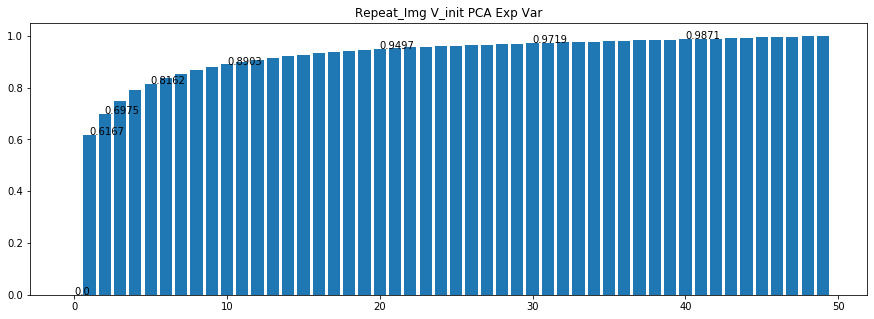

In [4]:
neural_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_repeat_neural.npy"
k_dim = 50
save_dir = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/"


repeat_V_init(neural_file, k_dim, save_dir)

# TRAIN U, V, W

In [4]:
class LinearNet(nn.Module):
    def __init__(self, unit_no, t_dim, k_dim, f_dim, p_dim):
        super(LinearNet, self).__init__()
        self.unit_no = unit_no
        self.t_dim = t_dim
        self.k_dim = k_dim
        self.f_dim = f_dim
        self.p_dim = p_dim
        
        self.V = nn.Linear(t_dim, k_dim, bias=False).cuda()
        self.U_list = nn.ModuleList([nn.Linear(k_dim, f_dim, bias=False).cuda() for i in range(unit_no)]).cuda()
        self.W_list = nn.ModuleList([nn.Linear(f_dim, p_dim, bias=False).cuda() for i in range(unit_no)]).cuda()
        
    def forward(self, S):
        self.batch = S.shape[0]
        
        ###### (50n) --> (kn) ####
        VS = torch.empty(self.batch, self.k_dim * self.unit_no).cuda()
        
        for i in range(self.unit_no):
            S_i = S[:,i,:].float().cuda()
            VS_i = self.V(S_i)
            VS[:, self.k_dim*i : self.k_dim*(i+1)] = VS_i
            
        ###### (kn) --> (2n) #####
        UVS = torch.empty(self.batch, self.f_dim * self.unit_no).cuda()
            
        for i in range(self.unit_no):
            VS_i = VS[:, self.k_dim*i : self.k_dim*(i+1)].float().cuda()
            U_i_func = self.U_list[i]
            UVS_i = U_i_func(VS_i)
            UVS[:, self.f_dim*i : self.f_dim*(i+1)] = UVS_i
        
        ##### (2n) --> (p) #####
        I = torch.zeros(self.batch, self.p_dim).cuda()
 
        for i in range(self.unit_no):
            UVS_i = UVS[:, self.f_dim*i : self.f_dim*(i+1)].float().cuda()
            W_i_func = self.W_list[i]
            I_i = W_i_func(UVS_i)
            I += I_i
        
        return I.float()
    
def V_sgd(W_init, U_init, S, I, V_init, index):
    batch_size = 64
    batch_count = I.shape[1]//batch_size
    
    unit_no = S.shape[1]
    t_dim = S.shape[2]
    k_dim = V_init.shape[0]
    f_dim = 2
    p_dim = I.shape[0]
    
    model = LinearNet(unit_no, t_dim, k_dim, f_dim, p_dim)
    model = model.float()
    model.cuda()
    
    # FREEZE W, U ###
    for i in range(unit_no):
        model.U_list[i].weight.requires_grad = False
        model.W_list[i].weight.requires_grad = False

    if index == 0:
        lr = 0.0025
    elif index == 1:
        lr = 0.000025
    elif index == 2:
        lr = 0.0000025
    print(lr)
    
    optimizer = optim.RMSprop(filter(lambda p: p.requires_grad , model.parameters()) , lr = lr)
    
    #milestones = [batch_count*1//4, batch_count // 2, batch_count * 3 // 4, batch_count * 7//8]
    #milestones = [batch_count // 2, batch_count * 3 // 4, batch_count * 7//8]
    #milestones = [batch_count*1//4, batch_count // 2, batch_count * 3 // 4]
    #milestones = [batch_count //2]
    #lr_decay = 0.75
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones,gamma=lr_decay)
    
    model.state_dict()["V.weight"][:] = torch.from_numpy(V_init)
    for i in tnrange(unit_no):
        model.state_dict()["U_list."+str(i)+".weight"][:] = torch.from_numpy(U_init[2*i : 2*(i+1), : ])
        model.state_dict()["W_list."+str(i)+".weight"][:] = torch.from_numpy(W_init[: , 2*i : 2*(i+1)])
    
    batch_ids = np.arange(9792)
    np.random.shuffle(batch_ids)
    batch_ids = batch_ids.reshape((-1,batch_size))
    
    S = torch.from_numpy(S)
    I = torch.from_numpy(I)
    
    first_corr = torch.empty(20,)
    final_corr = torch.empty(20,)
    loss_fn = torch.nn.MSELoss()
    
    for i in tnrange(batch_count):
        start_time = time.time()
        ids = batch_ids[i,:]
        
        batch_S = S[ids,:,:].cuda()
        batch_I = I[:,ids].cuda().T
        
        optimizer.zero_grad()
        decoded = model(batch_S.float())
        
        """
        batch_corr = audtorch.pearsonr(batch_I, decoded)
        mean_batch_corr = torch.mean(batch_corr)
        
        
        if i < 20:
            first_corr[i] = mean_batch_corr
        
        if i >= batch_count - 20:
            final_corr[i-batch_count+20] = mean_batch_corr
        
        #loss = -torch.sigmoid(mean_batch_corr)
        #loss = 1-mean_batch_corr
        """
        
        loss = loss_fn(decoded, batch_I)/p_dim
        
        if i < 20:
            first_corr[i] = loss
        
        if i >= batch_count - 20:
            final_corr[i-batch_count+20] = loss
        

        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        end_time = time.time()
        duration = end_time - start_time
        #print("Iter " +str(i)+ " Batch_Corr: " + str(mean_batch_corr.item()) + " , Time: " +str(duration))
        print("Iter " +str(i)+ " Batch_MSE: " + str(loss.item()) + " , Time: " +str(duration))
        
        
    print(torch.mean(first_corr).item())
    print(torch.mean(final_corr).item())
        
    V_new = model.V.weight.detach().cpu().numpy()
    
    return V_new



# V ONLY!!!!

In [3]:
U_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/lnn_altern_i3_u500_r100_U_weights.npy")[3].astype(np.float32)
V_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/lnn_altern_i3_u500_r100_V_weights.npy").astype(np.float32)
W_init = np.load("/ssd/joon/2017_11_29_ns/yass/weights/lnn_altern_i3_u500_r100_W_weights.npy")[2].astype(np.float32)
I = np.load("/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy").T.astype(np.float32)
S = np.load("/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy").astype(np.float32)

index = 2

sorted_units = np.load("/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy")
unit_no = 500
reg = 1
    
###### PARTIAL TRAIN #######
unit_ids = sorted_units[:unit_no]
unit_ids_2 = np.empty((unit_no*2,))

for i in range(unit_no):
    unit_ids_2[2*i] = sorted_units[i]*2
    unit_ids_2[2*i+1] = sorted_units[i]*2+1
unit_ids_2 = unit_ids_2.astype(np.int)
    
I = I[:, :]
S = S[:,unit_ids,:]
I_mean = np.mean(I, axis=1)
S_mean = np.mean(S, axis=0)
I = I-I_mean.reshape((-1,1))
S = S-S_mean



V_new = V_sgd(W_init, U_init, S, I, V_init[2], index)

save_dir = "/ssd/joon/2017_11_29_ns/yass/weights/"

V_sum = np.sum(np.abs(V_new))/V_new.size
V_exp = math.log10(V_sum)
V_new = V_new / V_sum*10**(V_exp*reg)

V_comb = np.concatenate((V_init[:3], V_new.reshape((1,V_new.shape[0], V_new.shape[1]))), 0)
print(V_comb.shape)
np.save(os.path.join(save_dir, "lnn_altern_i3_u500_r100_V_weights.npy"), V_comb)

5e-06


Iter 0 Batch_MSE: 0.004798414651304483 , Time: 0.6412913799285889
Iter 1 Batch_MSE: 0.005569661967456341 , Time: 0.5844099521636963
Iter 2 Batch_MSE: 0.004478263668715954 , Time: 0.36984920501708984
Iter 3 Batch_MSE: 0.004689176566898823 , Time: 0.411787748336792
Iter 4 Batch_MSE: 0.005111931823194027 , Time: 0.534935712814331
Iter 5 Batch_MSE: 0.005418931599706411 , Time: 0.3940114974975586
Iter 6 Batch_MSE: 0.00678780023008585 , Time: 0.432448148727417
Iter 7 Batch_MSE: 0.00494371447712183 , Time: 0.4078710079193115
Iter 8 Batch_MSE: 0.005274731665849686 , Time: 0.40854740142822266
Iter 9 Batch_MSE: 0.004463159013539553 , Time: 0.4992220401763916
Iter 10 Batch_MSE: 0.0046944571658968925 , Time: 0.3940267562866211
Iter 11 Batch_MSE: 0.004652104340493679 , Time: 0.48093605041503906
Iter 12 Batch_MSE: 0.004807295743376017 , Time: 0.4659557342529297
Iter 13 Batch_MSE: 0.004986083135008812 , Time: 0.5219054222106934
Iter 14 Batch_MSE: 0.004614260513335466 , Time: 0.41412854194641113
Iter 

Iter 122 Batch_MSE: 0.004664745647460222 , Time: 0.42121434211730957
Iter 123 Batch_MSE: 0.004839495290070772 , Time: 0.5540106296539307
Iter 124 Batch_MSE: 0.00498343538492918 , Time: 0.5152938365936279
Iter 125 Batch_MSE: 0.005442197900265455 , Time: 0.49118995666503906
Iter 126 Batch_MSE: 0.0052037425339221954 , Time: 0.4291813373565674
Iter 127 Batch_MSE: 0.004940042272210121 , Time: 0.4273641109466553
Iter 128 Batch_MSE: 0.005504757631570101 , Time: 0.4065122604370117
Iter 129 Batch_MSE: 0.005459359847009182 , Time: 0.40496826171875
Iter 130 Batch_MSE: 0.004752821289002895 , Time: 0.5403618812561035
Iter 131 Batch_MSE: 0.004886444192379713 , Time: 0.41674375534057617
Iter 132 Batch_MSE: 0.004703889135271311 , Time: 0.44130873680114746
Iter 133 Batch_MSE: 0.004709333647042513 , Time: 0.5664045810699463
Iter 134 Batch_MSE: 0.005325764417648315 , Time: 0.4053993225097656
Iter 135 Batch_MSE: 0.0046790349297225475 , Time: 0.42703843116760254
Iter 136 Batch_MSE: 0.004604886285960674 , T

# FULL TRAIN FUNCTIONS

In [2]:
def altern_iter(I, S, U_old, V_old, W_old, reg, index):
    start_time = time.time()
    
    p_dim = I.shape[0]
    image_no = I.shape[1]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = S.shape[1]
    k_dim = V_old.shape[0]
    
    #### T = VS (n,k,t x 1) VEC PREPARATION ####
    T_vec = np.empty((unit_no*k_dim*image_no,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for t in range(image_no):
                T_knt = cp.dot(V_old[k,:] , S[t,n,:])
                T_vec[n*k_dim*image_no + k*image_no + t] = T_knt
    
    ##### U CALCULATION ####
    ######################
    
    ######### MAKE XX #######
    XTX = np.zeros((f_dim * unit_no * k_dim , f_dim * unit_no * k_dim), dtype=np.float32)
    
    for n1 in tnrange(unit_no):
        for n2 in range(unit_no):
            for k1 in range(k_dim):
                for k2 in range(k_dim):
                    for i1 in range(f_dim):
                        for i2 in range(f_dim):
                            index1 = n1*k_dim*f_dim + k1*f_dim + i1
                            index2 = n2*k_dim*f_dim + k2*f_dim + i2
                            if index1 >= index2:
                                TT = cp.dot(T_vec[image_no*(n1*k_dim+k1):image_no*(n1*k_dim+k1+1)],
                                            T_vec[image_no*(n2*k_dim+k2):image_no*(n2*k_dim+k2+1)])
                                XTX_entry = cp.dot(W_old[:, n1*f_dim+i1] , W_old[:, n2*f_dim+i2]) * TT
                                XTX[n1*k_dim*f_dim + k1*f_dim + i1, n2*k_dim*f_dim + k2*f_dim + i2] = XTX_entry
                                XTX[n2*k_dim*f_dim + k2*f_dim + i2, n1*k_dim*f_dim + k1*f_dim + i1] = XTX_entry
    
    
    ######## MAKE XY ########
    XTY = np.zeros((f_dim * unit_no * k_dim ,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                TI_nkx = cp.dot(T_vec[image_no*(n*k_dim+k):image_no*(n*k_dim+k+1)] , I.T)
                XTY[n*k_dim*f_dim + k*f_dim + i] = cp.dot(TI_nkx , W_old[:, n*f_dim+i])
    
    
    XTX_inv = linalg.inv(XTX + 0.0000001*np.identity(XTX.shape[0], dtype=np.float32))
    
    U_old = cp.dot(XTX_inv, XTY)
    
    #### U STANDARDIZE ######
    U_sum = np.sum(np.abs(U_old))/U_old.size
    U_exp = math.log10(U_sum)    
    U_old = U_old/U_sum*10**(U_exp*reg)
    #######
    
    """
    ##### RESHAPE U ######
    
    U_new = np.empty((f_dim*unit_no , k_dim), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                U_new[f_dim*n + i , k] = U_old[n*f_dim*k_dim + k*f_dim + i]
                
    U_old = U_new

    
    ##### Estimate V #####
    
    V_old = V_sgd(W_old, U_old, S, I, V_old, index)
    
    ##### STANDARDIZE V #######

    V_sum = np.sum(np.abs(V_old))/V_old.size
    V_exp = math.log10(V_sum)
    V_old = V_old / V_sum*10**(V_exp*reg)
    
    ##### RESHAPE U ######
    
    U_new = np.empty((f_dim*unit_no*k_dim ,), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                U_new[n*f_dim*k_dim + k*f_dim + i] = U_old[f_dim*n + i , k]
                
    U_old = U_new
    """
    
    ######## W CALCULATION #######
    #######################
    X = np.empty((image_no, unit_no*f_dim), dtype=np.float32)
    
    for t in tnrange(image_no):
        for n in range(unit_no):
            for i in range(f_dim):
                T_ids = np.arange(0, k_dim*image_no, image_no) + n*image_no*k_dim + t
                U_ids = np.arange(0, k_dim*f_dim, f_dim) + n*k_dim*f_dim + i
                
                X[t, n*f_dim + i] = cp.dot(T_vec[T_ids].reshape((1,-1)) , U_old[U_ids].reshape((-1,1)))
    
    W_old = np.linalg.lstsq(X, I.T)[0].T
    
    ##### W STANDARDIZE #####
    W_sum =np.sum(np.abs(W_old))/W_old.size
    W_exp = math.log10(W_sum)
    W_old = W_old/W_sum*10**(W_exp*reg)
    ##################
    
    ##### RESHAPE U ######
    
    U_new = np.empty((f_dim*unit_no , k_dim), dtype=np.float32)
    
    for n in tnrange(unit_no):
        for k in range(k_dim):
            for i in range(f_dim):
                U_new[f_dim*n + i , k] = U_old[n*f_dim*k_dim + k*f_dim + i]
                
    U_old = U_new
    
    end_time = time.time()
    print(end_time - start_time)
    return U_old, V_old, W_old




In [3]:
def altern_train(I_file, S_file, U_file, V_file, W_file, sorted_file, unit_no, pixel_no, image_no, iter_no,
                 reg, save_dir):
    
    I = np.load(I_file).T.astype(np.float32)
    S = np.load(S_file).astype(np.float32)
    U = np.load(U_file).astype(np.float32)
    V = np.load(V_file).astype(np.float32)
    W = np.load(W_file).T[:,:-1].astype(np.float32)
    sorted_units = np.load(sorted_file)
    
    ###### PARTIAL TRAIN #######
    unit_ids = sorted_units[:unit_no]
    unit_ids_2 = np.empty((unit_no*2,))
    
    for i in range(unit_no):
        unit_ids_2[2*i] = sorted_units[i]*2
        unit_ids_2[2*i+1] = sorted_units[i]*2+1
    unit_ids_2 = unit_ids_2.astype(np.int)
    
    U = U[unit_ids_2, :]
    W = W[:pixel_no, unit_ids_2]
    
    I = I[:pixel_no, :image_no]
    S = S[:image_no,unit_ids,:]
    I_mean = np.mean(I, axis=1)
    S_mean = np.mean(S, axis=0)
    I = I-I_mean.reshape((-1,1))
    S = S-S_mean

    ###########
    
    #V = np.hstack((V, np.zeros((V.shape[0],1), dtype = np.float32)))
    
    U_train = np.empty((iter_no+1, U.shape[0], U.shape[1]), dtype=np.float32)
    V_train = np.empty((iter_no+1, V.shape[0], V.shape[1]), dtype=np.float32)
    W_train = np.empty((iter_no+1, W.shape[0], W.shape[1]), dtype=np.float32)
    
    U_sum = np.sum(np.abs(U))/U.size
    U_exp = math.log10(U_sum)    
    U = U/U_sum*10**(U_exp*reg)
    
    V_sum = np.sum(np.abs(V))/V.size
    V_exp = math.log10(V_sum)    
    V = V/V_sum*10**(V_exp*reg)
    
    W_sum = np.sum(np.abs(W))/W.size
    W_exp = math.log10(W_sum)    
    W = W/W_sum*10**(U_exp*reg)
    
    U_train[0] = U
    V_train[0] = V
    W_train[0] = W

    for i in tnrange(iter_no):
        
        U, V, W = altern_iter(I, S, U_train[i], V_train[i], W_train[i], reg, i)
        U_train[i+1] = U
        V_train[i+1] = V
        W_train[i+1] = W
        
    np.save(os.path.join(save_dir, "noV_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(int(100*reg))+"_U_weights.npy"), U_train)
    np.save(os.path.join(save_dir, "noV_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(int(100*reg))+"_V_weights.npy"), V_train)
    np.save(os.path.join(save_dir, "noV_altern_i"+str(iter_no)+"_u"+str(unit_no)+"_r"+str(int(100*reg))+"_W_weights.npy"), W_train)

In [4]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy"
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_YS_k7_U_init.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/reduced_rank/yass_repeat_k7_V_init.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/yass_smooth_4_weights.npy"
iter_no = 3
unit_no = 1600
pixel_no = 95*146
image_no = 9800
reg = 1
sorted_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/weights/"



altern_train(I_file, S_file, U_file, V_file, W_file, sorted_file, unit_no, pixel_no, image_no, iter_no,
                 reg, save_dir)

/home/joon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



8161.277502536774



8208.388799667358



11284.592806816101



# CONSTANT TRAIN

In [2]:
def altern_const_train(I_file, S_file, U_file, V_file, W_file, sorted_file, save_dir):
    I = np.load(I_file).T
    S = np.load(S_file)
    U = np.load(U_file)
    V = np.load(V_file)
    W = np.load(W_file)
    sorted_units = np.load(sorted_file)
    
    unit_ids = sorted_units[:1600]
    
    #I = I[:730, :]
    S = S[:,unit_ids,:]
    
    #p_dim = I.shape[0]
    #image_no = I.shape[1]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = W.shape[0]//2
    k_dim = V.shape[1]
    iter_no = U.shape[0]
    
    #C_array = np.empty((730, 3*iter_no-2))
    C = np.mean(I[:,:], axis=1).reshape((-1,1))
    C = np.tile(C, (1,3*iter_no-2))
    print(C.shape)
    S = np.mean(S, axis = 0)
    print(S.shape)
    
    ###### C CALCULATION ######
    
    for i in tnrange(3*iter_no-2):

        for n in range(unit_no):

            if i%3 == 0:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3, :, 2*n : 2*n+2] , U[i//3, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
            
            elif i%3 == 1:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3, :, 2*n : 2*n+2] , U[i//3+1, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
            
            elif i%3 == 2:
                S_avg = S[n,:].reshape((-1,1))
                WUn = cp.dot(W[i//3, :, 2*n : 2*n+2] , U[i//3+1, 2*n:2*n+2 , :])
                VS_avg = cp.dot(V[i//3+1] , S_avg)
                C[:,i] -= cp.dot(WUn, VS_avg).reshape((-1,))
    
    
    np.save(os.path.join(save_dir, "noV_altern_"+U_file[-27:-14] +"_C_weights.npy"), C)
    

In [3]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_train_images.npy"
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_train_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_U_weights.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_V_weights.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_W_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/weights/"
sorted_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"




altern_const_train(I_file, S_file, U_file, V_file, W_file, sorted_file, save_dir)

(13870, 10)
(1600, 50)


# Decode

In [4]:
def altern_decode(S_file, U_file, V_file, W_file, C_file, sorted_file, save_dir):

    S = np.load(S_file)
    U = np.load(U_file)
    V = np.load(V_file)
    W = np.load(W_file)
    C = np.load(C_file).T
    sorted_units = np.load(sorted_file)
    
    unit_ids = sorted_units[:1600]
    
    S = S[:,unit_ids,:]
    
    p_dim = W.shape[1]
    image_no = S.shape[0]
    t_dim = S.shape[2]
    f_dim = 2
    unit_no = unit_ids.shape[0]
    k_dim = V.shape[1]
    iter_no = U.shape[0]
    
    

    altern_decoded = np.zeros((3*iter_no-2, image_no, p_dim))
    
    for i in tnrange(3*iter_no-2):

        for n in range(unit_no):
            if i%3 == 0:
                S_part = S[:,n,:].T
                WUn =  cp.dot(W[i//3,:,2*n:2*n+2] , U[i//3,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            elif i%3 == 1:
                S_part = S[:,n,:].T
                WUn = cp.dot(W[i//3,:,2*n:2*n+2] , U[i//3+1,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            elif i%3 == 2:
                S_part = S[:,n,:].T
                WUn = cp.dot(W[i//3,:,2*n:2*n+2] , U[i//3+1,2*n:2*n+2 , :])
                VS_part = cp.dot(V[i//3+1], S_part)
                altern_decoded[i,:,:] += cp.dot(WUn, VS_part).T
            
            
    print(altern_decoded.shape)
            
    for i in tnrange(3*iter_no-2):
            altern_decoded[i,:] += C[i,:].reshape((1,p_dim))
            
            
    np.save(os.path.join(save_dir, "yass_noV_altern_"+U_file[-27:-14]+"_test_decoded.npy"), altern_decoded)
    
    
    


In [ ]:
S_file = "/ssd/joon/2017_11_29_ns/yass/neural/yass_50_test_neural.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_U_weights.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_V_weights.npy"
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_W_weights.npy"
C_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i3_u1600_r100_C_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/decoded/"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"



altern_decode(S_file, U_file, V_file, W_file, C_file, sorted_units_file, save_dir)

# Testing CORRELATION

In [10]:
def altern_corr(I_file, altern_file, simple_file, save_dir):
    test = np.load(I_file)[:,:]
    altern = np.load(altern_file)
    simple = np.load(simple_file)[:,:]
    
    iter_no = altern.shape[0]
    image_no = altern.shape[1]
    
    corr_array = np.empty((image_no, iter_no+1))
    print(corr_array.shape)
    
    for i in tnrange(image_no):
        test_img = test[i,:]
        simple_img = simple[i,:]
        simple_corr = np.corrcoef(test_img.reshape(-1), simple_img.reshape(-1))[0][1]
        corr_array[i,0] = simple_corr
        
        for j in range(iter_no):
            altern_img = altern[j,i,:]
            altern_corr = np.corrcoef(test_img.reshape(-1), altern_img.reshape(-1))[0][1]
            corr_array[i,j+1] = altern_corr
    
    mean_corr_array = np.nanmean(corr_array, axis=0)
    print(mean_corr_array)
    
    np.save(os.path.join(save_dir, "noV_altern_"+str(altern_file[-30:-17]) +"_test_corr.npy"), mean_corr_array)
    

In [11]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_noV_altern_i3_u1600_r100_test_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/test_corr/"



altern_corr(I_file, altern_file, simple_file, save_dir)

(100, 5)



[ 0.96366828 -0.06463396  0.95723472  0.95723472  0.9569003 ]


[ 0.96366828 -0.07860174  0.9369231   0.9369231   0.94452837  0.94665673
  0.94665673  0.94664064  0.94718469  0.94718469  0.9468725 ]


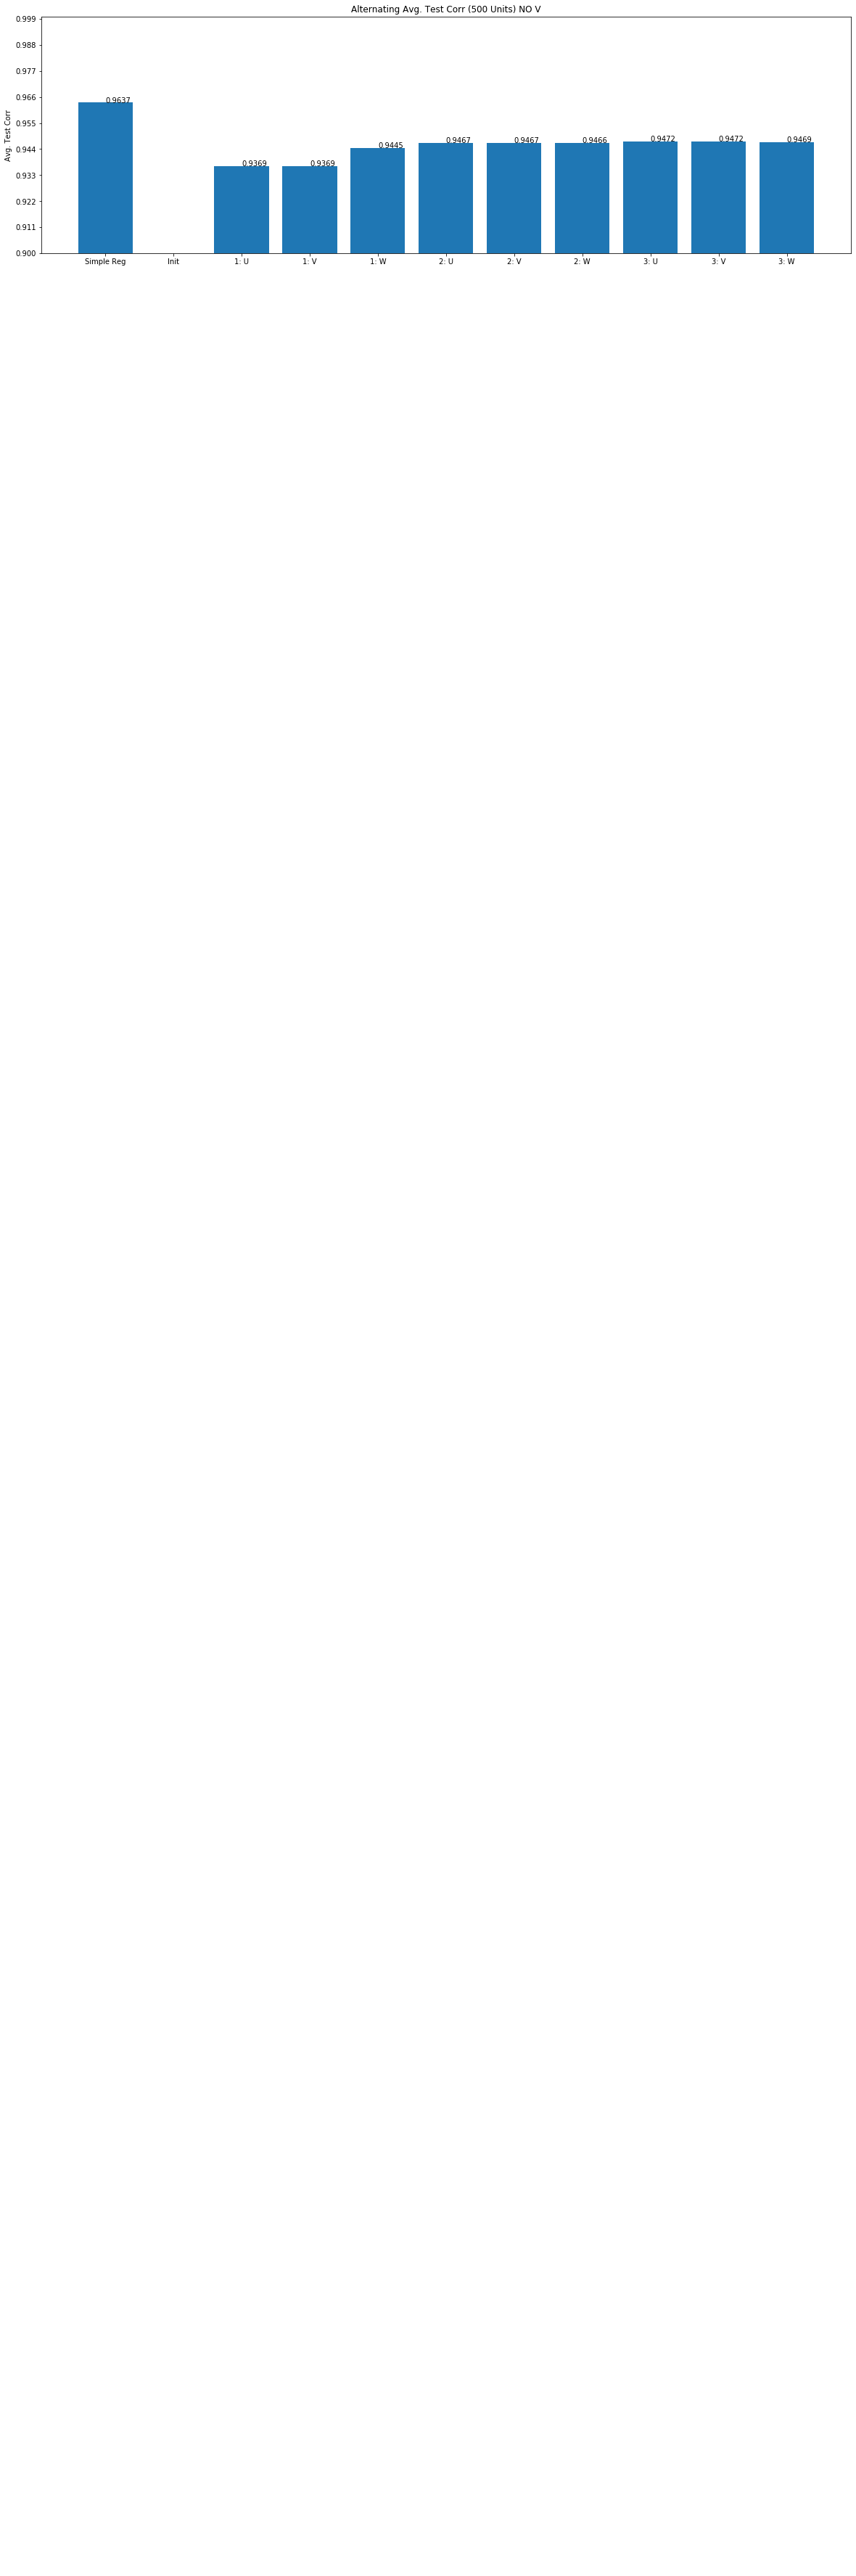

In [16]:
corr_bars = np.load("/ssd/joon/2017_11_29_ns/yass/test_corr/noV_altern_i3_u500_r100_test_corr.npy")
x_labels = ["Simple Reg", "Init", "1: U", "1: V", "1: W",
           "2: U", "2: V", "2: W",
            "3: U", "3: V", "3: W"]
           #"4: U", "4: V", "4: W"]
            #"5: U", "5: V", "5: W",
            #"6 U", "6: V", "6: W"]
plt.figure(figsize = (20,6))

plt.bar(x_labels, corr_bars)
plt.yticks(np.arange(0.9,1.001, 0.011))
plt.ylim(0.9,1)
plt.ylabel("Avg. Test Corr")
plt.title("Alternating Avg. Test Corr (500 Units) NO V")
for i in range(len(x_labels)):
    plt.annotate(str(round(corr_bars[i], 4)) , xy = (x_labels[i], corr_bars[i]))

print(corr_bars)

# MSE CALCULATION & PLOT

In [19]:
def altern_mse(I_file, altern_file, simple_file, save_dir):
    test = np.load(I_file)[:,:]
    altern = np.load(altern_file)
    simple = np.load(simple_file)[:,:]
    
    iter_no = altern.shape[0]
    image_no = altern.shape[1]
    
    mse_array = np.empty((image_no, iter_no+1))
    
    
    for j in range(iter_no):
    
        for i in range(image_no):
            test_img = test[i,:]
            simple_img = simple[i,:]
            simple_mse = np.sum(np.square(test_img - simple_img))
            mse_array[i,0] = simple_mse
            
            
            altern_img = altern[j,i,:]
            img_mse = np.sum(np.square(test_img - altern_img))
            mse_array[i,j+1] = img_mse
    
    mean_mse_array = np.log(np.mean(mse_array, axis=0))
    print(mean_mse_array)
    
    np.save(os.path.join(save_dir, "lnn_altern_"+str(altern_file[-28:-17]) +"_test_mse.npy"), mean_mse_array)

In [20]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_lnn_altern_i1_u500_r50_test_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/test_corr/"




altern_mse(I_file, altern_file, simple_file, save_dir)

[14.58536949 21.89157915 15.0195451  16.09077035 17.21797455]


[14.58536949 21.89157915 15.0195451  16.09077035 17.21797455]


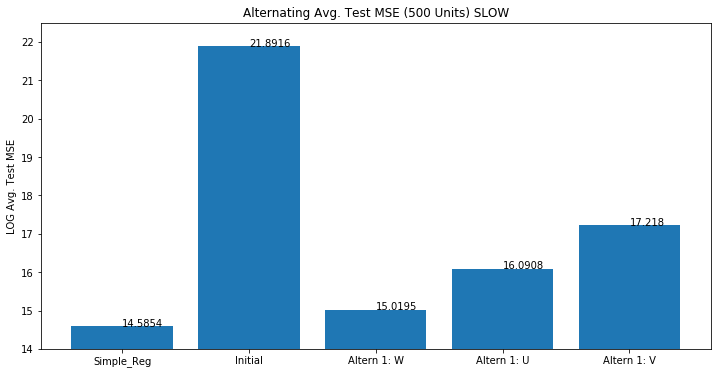

In [21]:
mse_bars = np.load("/ssd/joon/2017_11_29_ns/yass/test_corr/lnn_altern_i1_u500_r50_test_mse.npy")
x_labels = ["Simple_Reg", "Initial", "Altern 1: W", "Altern 1: U", "Altern 1: V"]
           #"Altern 2: W", "Altern 2: U", "Altern 2: V"]
            #"Altern 3: W", "Altern 3: U", "Altern 3: V"]
           #"Altern 4: W", "Altern 4: U", "Altern 4: V",
            #"Altern 5: W", "Altern 5: U", "Altern 5: V",
           #"Altern 6 W", "Altern 6: U", "Altern 6: V"]
plt.figure(figsize = (12,6))

plt.bar(x_labels, mse_bars)
plt.ylabel("LOG Avg. Test MSE")
plt.ylim(14,22.5)
plt.title("Alternating Avg. Test MSE (500 Units) FAST")
for i in range(len(x_labels)):
    plt.annotate(str(round(mse_bars[i], 4)) , xy = (x_labels[i], mse_bars[i]))

print(mse_bars)

# PLOT IMAGES

In [63]:
def plot_decoded(I_file, simple_file, altern_file, index, save_dir):
    
    test = np.load(I_file)[:3000, :2190]
    simple = np.load(simple_file)[:3000, :2190]
    altern = np.load(altern_file)
    
    iter_no = altern.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no+2, figsize = (14, 5))
    
    img0 = axs[0].imshow(test[index, :].reshape((15, 146)).T, cmap = "Greys_r")
    img1 = axs[1].imshow(simple[index, :].T.reshape((15, 146)).T, cmap = "Greys_r")
    
    for i in range(iter_no):
        axs[i+2].imshow(altern[i, index, :].T.reshape((15, 146)).T, cmap = "Greys_r")
    
    #plt.colorbar(img0, ax=axs[0], shrink = 0.4)
    #plt.colorbar(img1, ax=axs[1], shrink = 0.4)
    #plt.colorbar(img2, ax=axs[2], shrink = 0.4)
    #plt.colorbar(img3, ax=axs[3], shrink = 0.4)
    
    axs[0].set_title("True")
    axs[1].set_title("YASS")
    axs[2].set_title("Altern Init")
    
    for i in range(iter_no//3):
        axs[3*(i+1)].set_title("Train " +str(i)+" U")
        axs[3*(i+1)+1].set_title("Train " +str(i)+" W")
        axs[3*(i+1)+2].set_title("Train " +str(i)+" V")
    
    for i in range(iter_no+2):
        axs[i].axis("off")
    
    fig.suptitle("Image "+str(index)+": YASS vs. Alternating Comparison", fontsize = 16)
    
def multi_plot_decoded(I_file, simple_file, altern_file, plot_no, save_dir):
    
    with PdfPages(os.path.join(save_dir, "part_altern_3_yass_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            index = np.random.randint(0, 100)
            fig = plot_decoded(I_file, simple_file, altern_file, index, save_dir)
            pdf.savefig(fig)
    
    

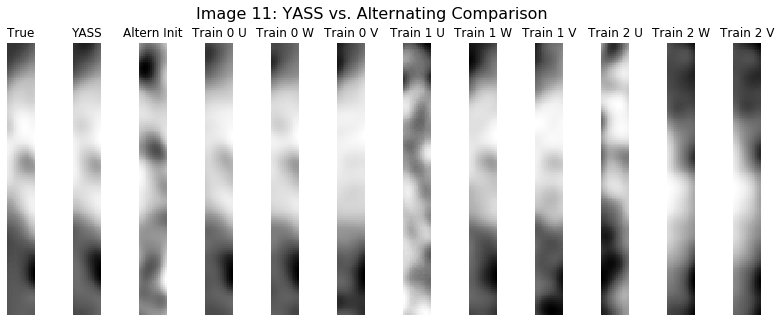

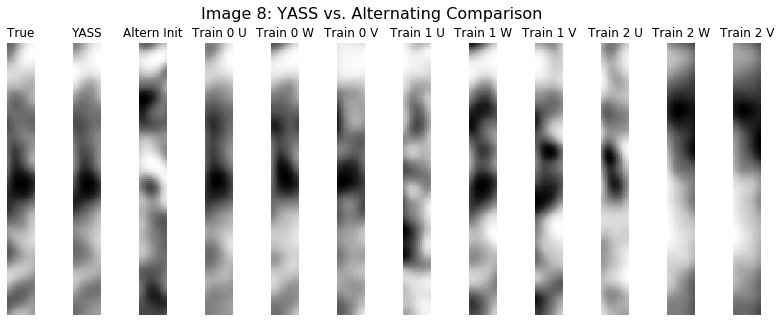

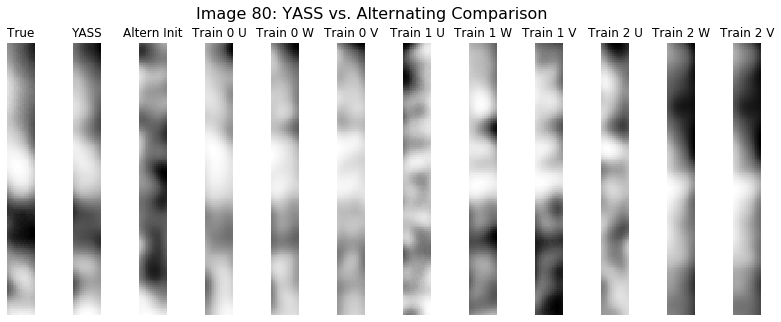

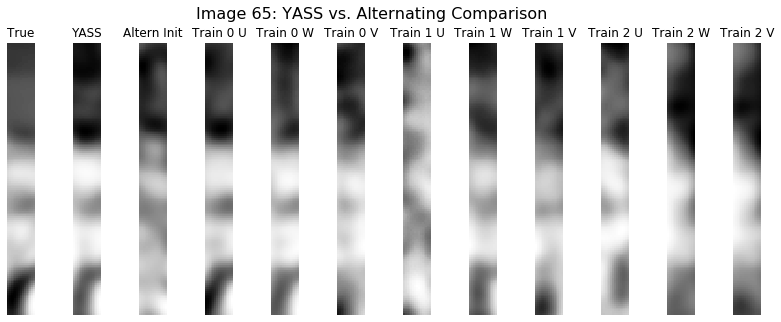

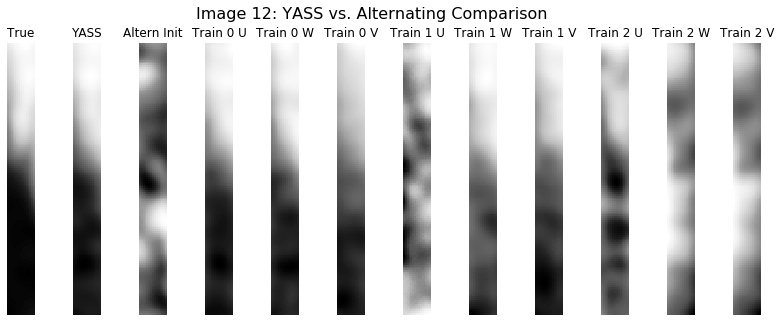

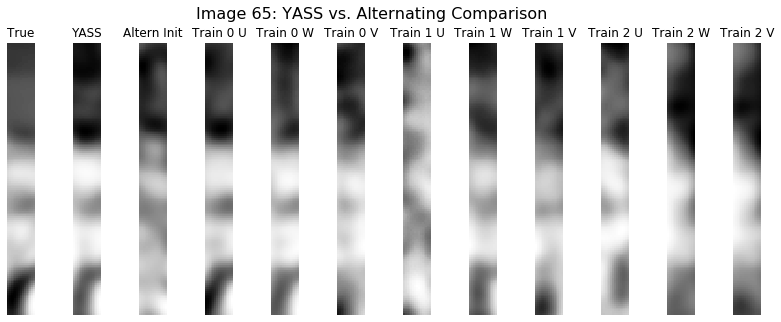

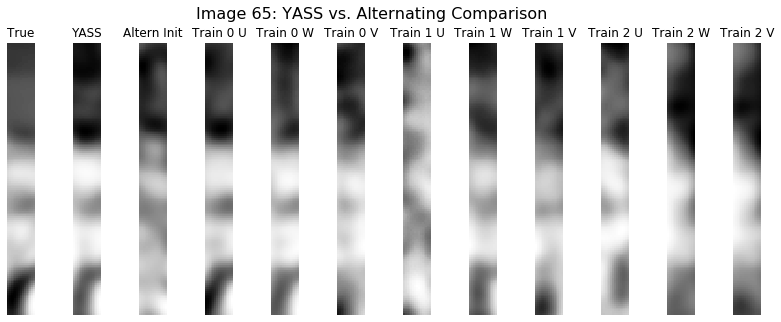

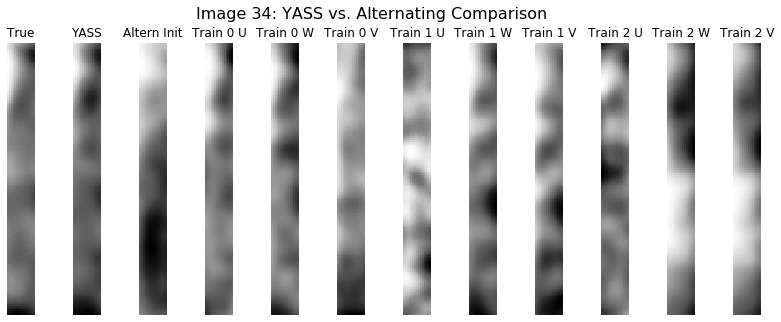

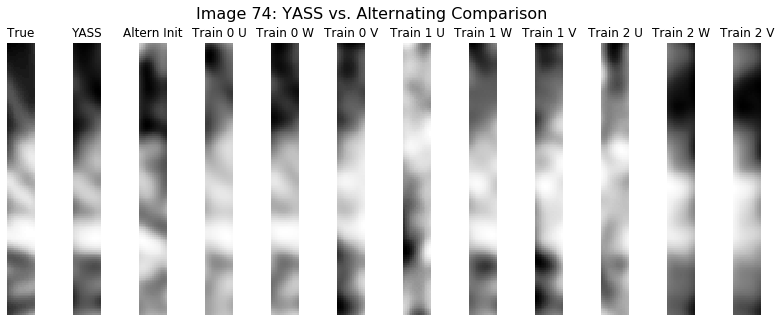

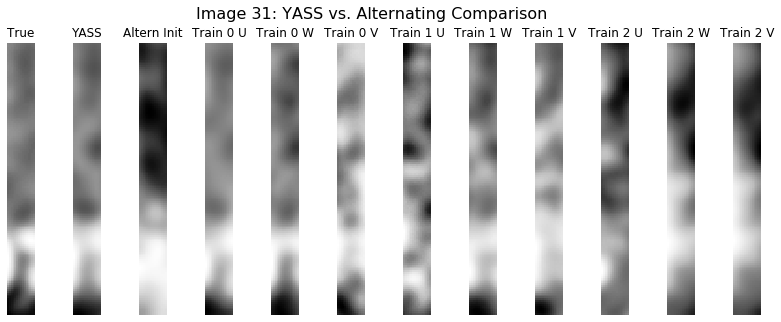

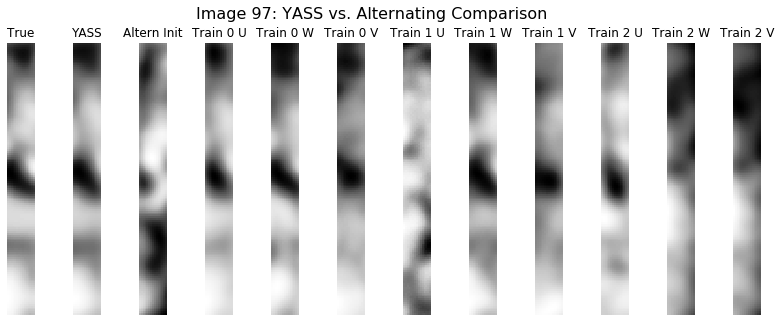

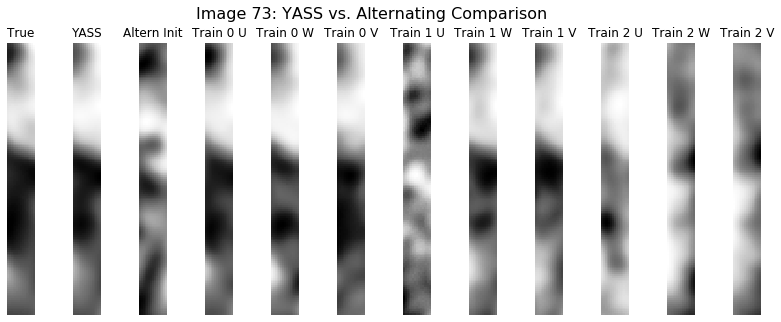

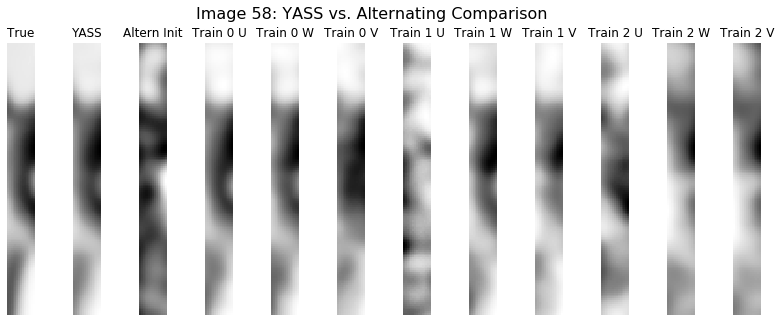

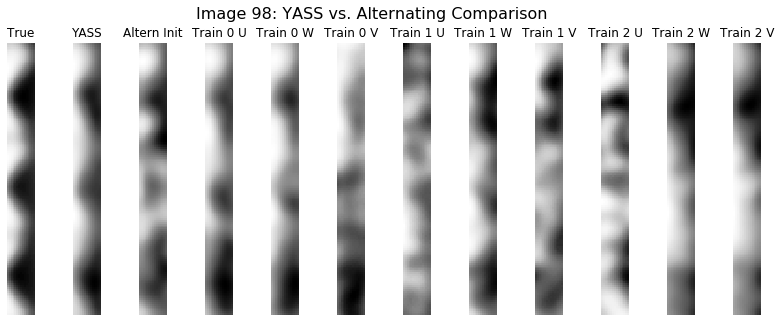

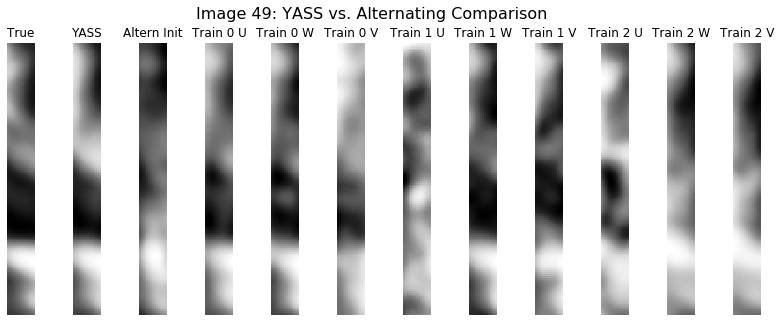

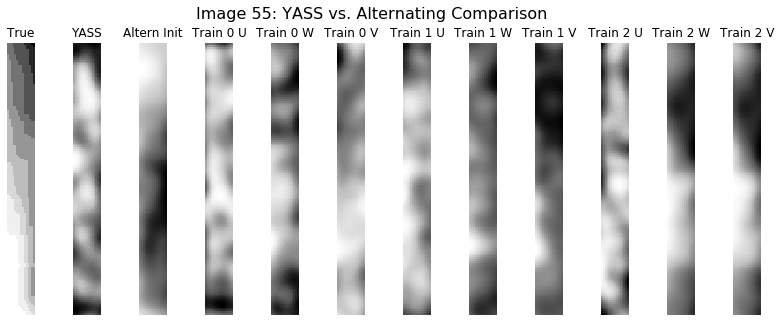

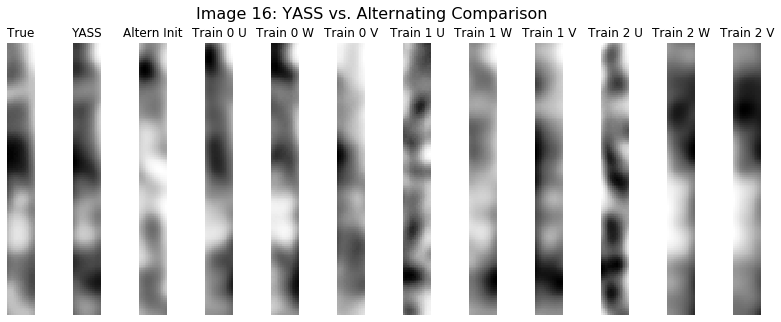

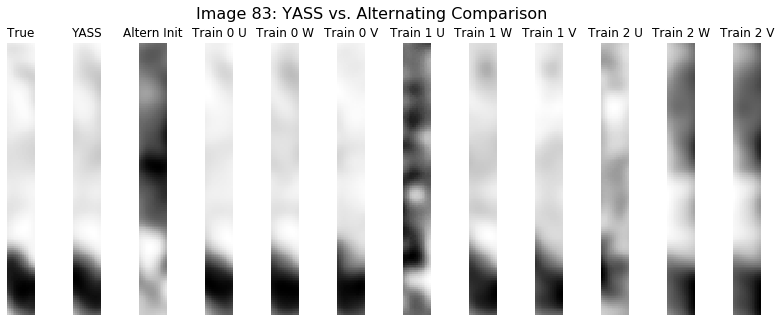

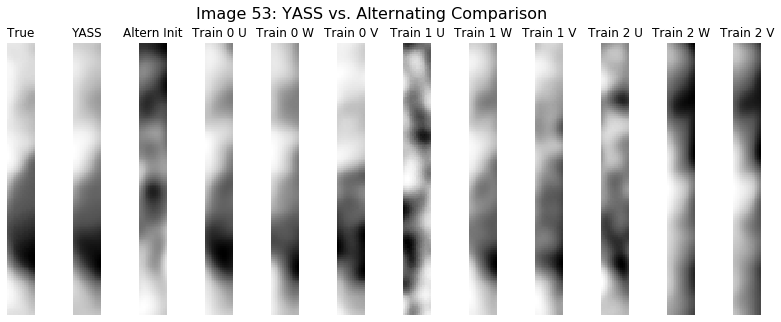

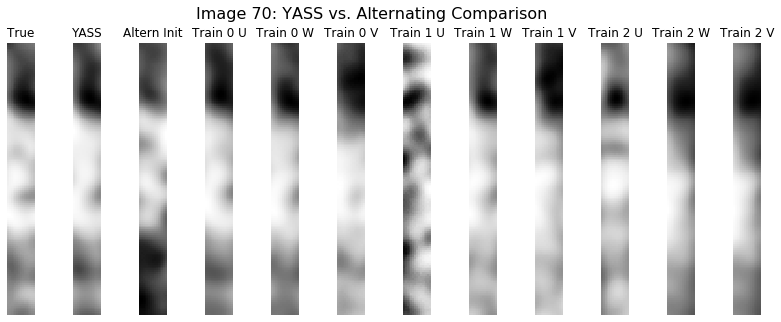

In [64]:
I_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
altern_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_part_altern_3_test_decoded.npy"
simple_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
plot_no = 20

multi_plot_decoded(I_file, simple_file, altern_file, plot_no, save_dir)

# Plot Weights

In [20]:
def comb_plot_weights(W_file, U_file, V_file, unit):
    U = np.load(U_file)
    W = np.load(W_file)
    V = np.load(V_file)
    
    iter_no = U.shape[0]
    
    fig, axs = plt.subplots(nrows = 4, ncols = iter_no, figsize = (12,10))
    
    for i in range(iter_no):
        axs[0,i].imshow(W[i,:,2*unit].reshape((95,146)))
        axs[2,i].imshow(W[i,:,2*unit+1].reshape((95,146)))
        axs[0,i].axis("off")
        axs[2,i].axis("off")
        
        axs[1,i].plot(np.arange(V.shape[2]), np.matmul(U[i,2*unit,:], V[i]).reshape((-1,1)))
        axs[3,i].plot(np.arange(V.shape[2]), np.matmul(U[i,2*unit+1,:], V[i]).reshape((-1,1)))
        
        axs[0,i].set_title("Step"+str(i)+" ON " + "AbsMax: "+str(np.round(np.max(np.abs(W[i,:,2*unit])), 2)))
        axs[2,i].set_title("Step"+str(i)+ " OFF " + "AbsMax: "+str(np.round(np.max(np.abs(W[i,:,2*unit+1])), 2)))
        
        axs[1,i].set_title("AbsMax: "+str(np.round(np.max(np.abs(np.matmul(U[i,2*unit,:], V[i]))), 2)))
        axs[3,i].set_title("AbsMax: "+str(np.round(np.max(np.abs(np.matmul(U[i,2*unit+1,:], V[i]))), 2)))
        
    fig.suptitle(str(unit)+"'th Best U, V, W Weights", fontsize = 16)
    #fig.tight_layout()

def multi_comb_plot_weights(W_file, U_file, V_file, unit_no, save_dir):
    with PdfPages(os.path.join(save_dir, "yass_noV_altern_i3_u500_r100_comb_weights.pdf")) as pdf:
        for i in tnrange(unit_no):
            unit = i
            fig = comb_plot_weights(W_file, U_file, V_file, unit)
            pdf.savefig(fig)

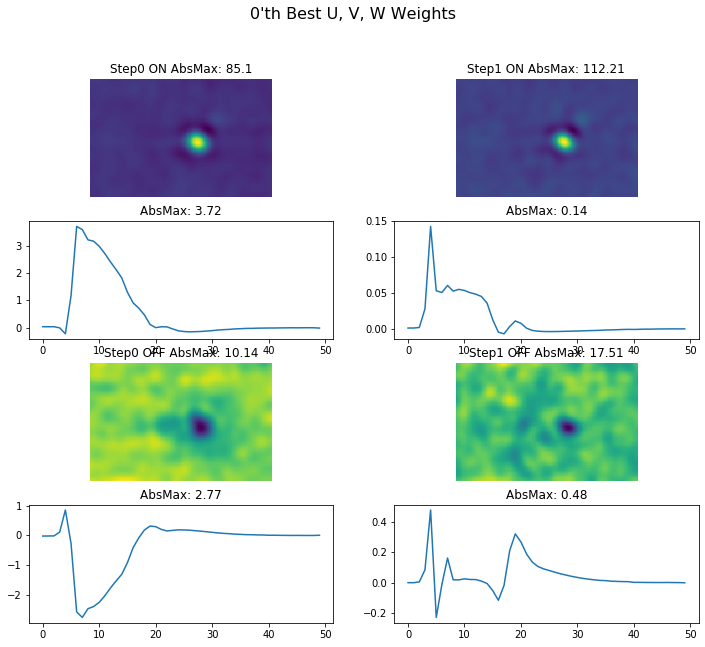

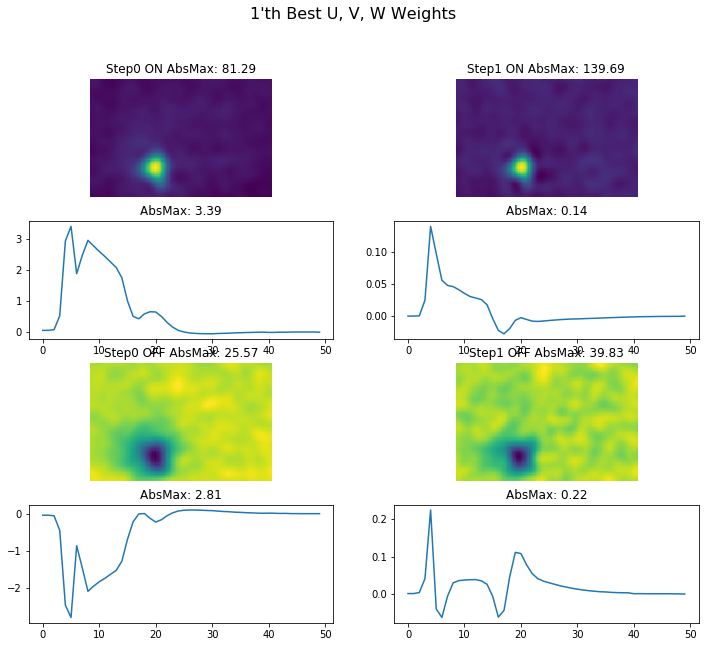

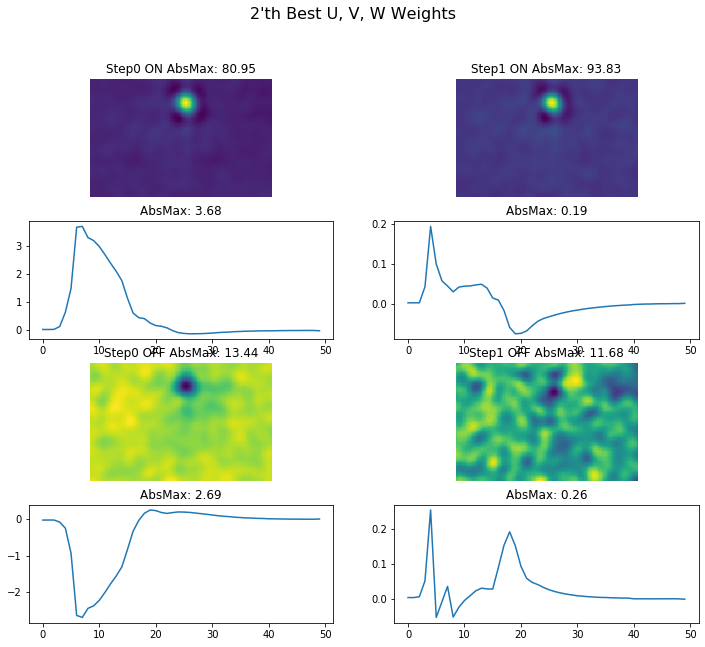

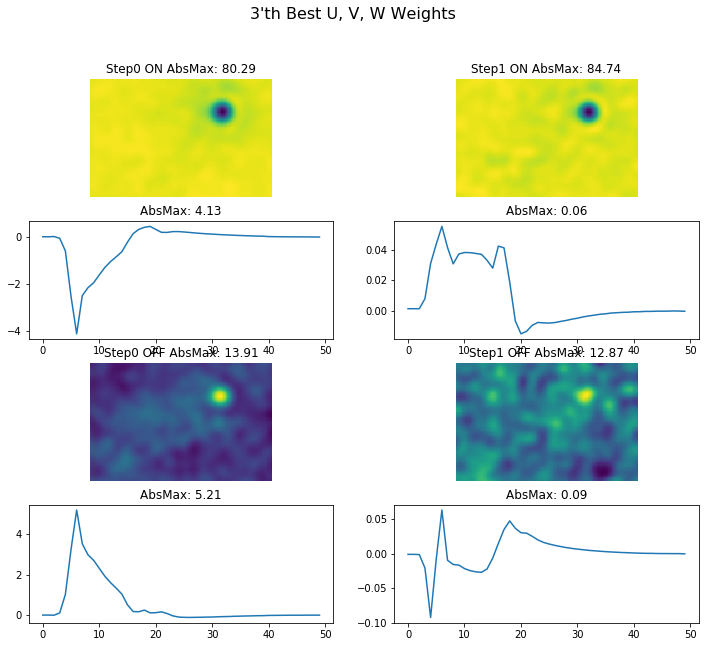

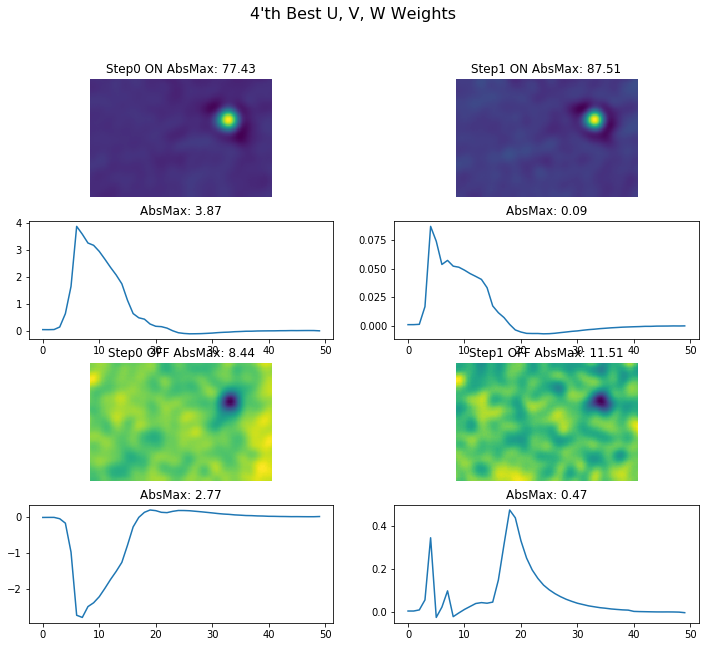

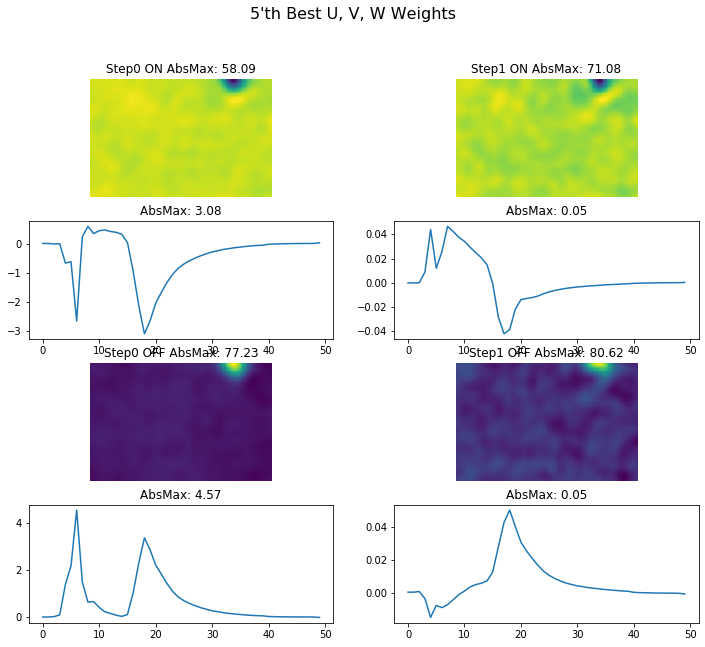

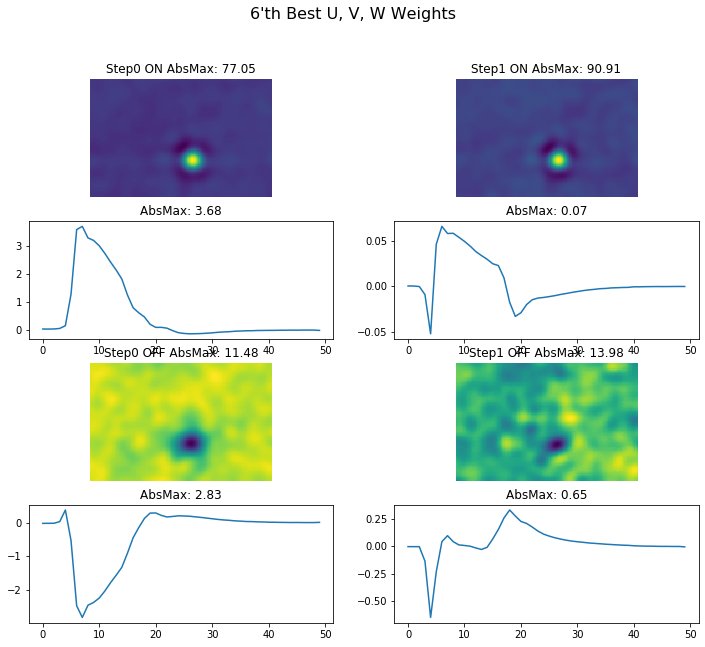

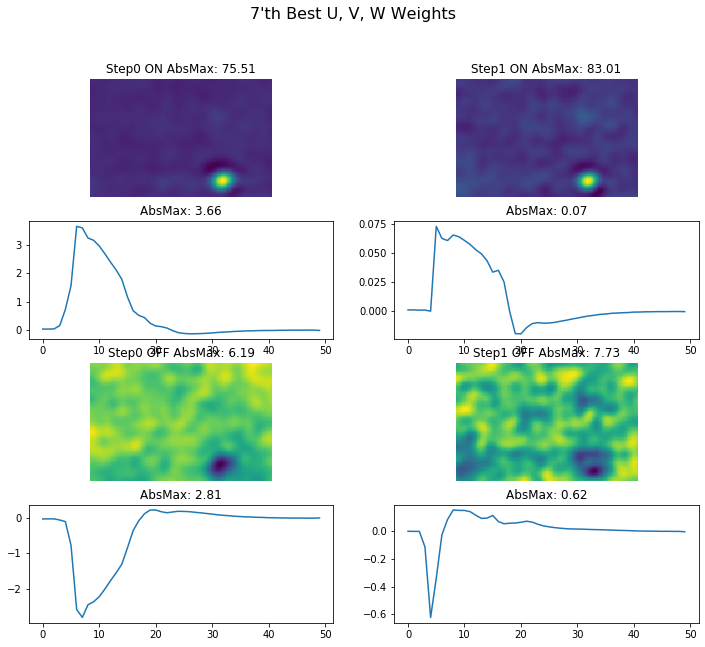

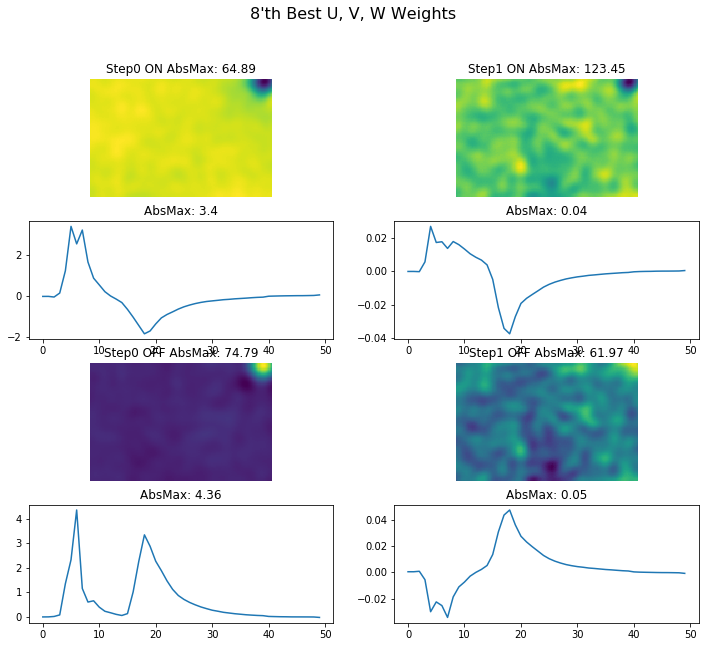

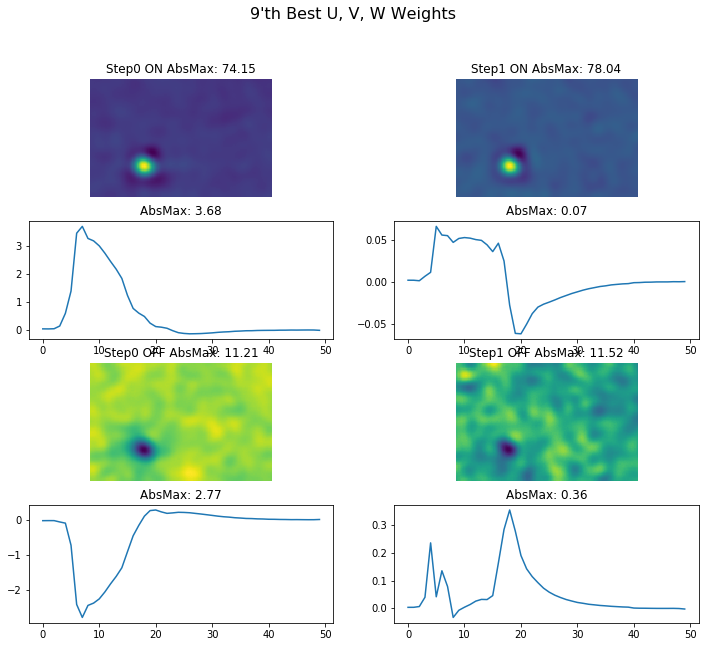

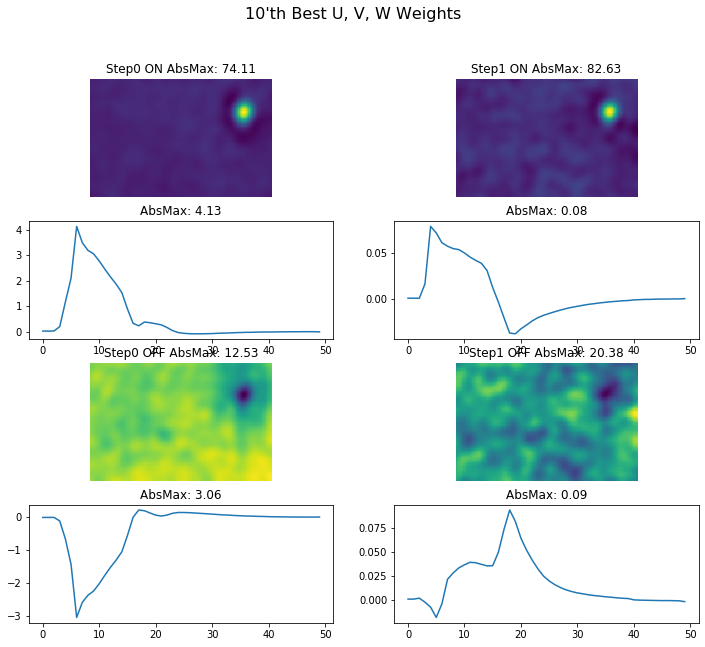

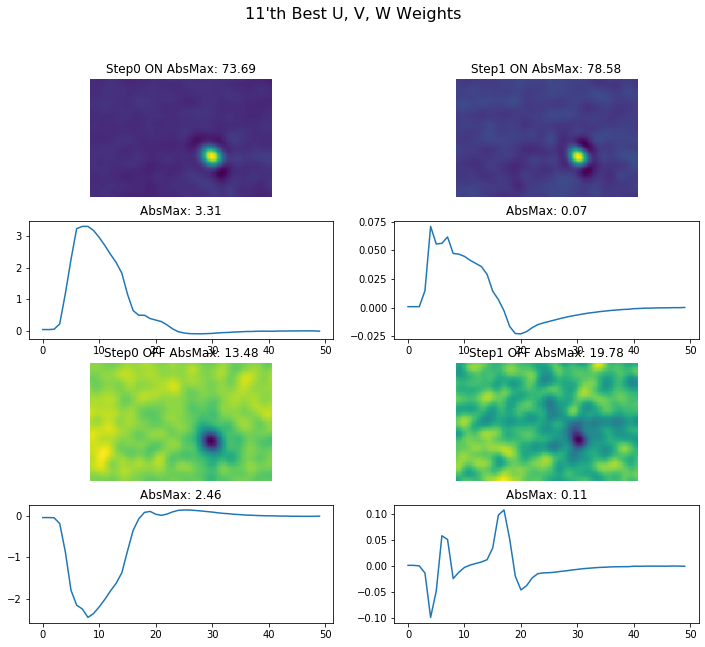

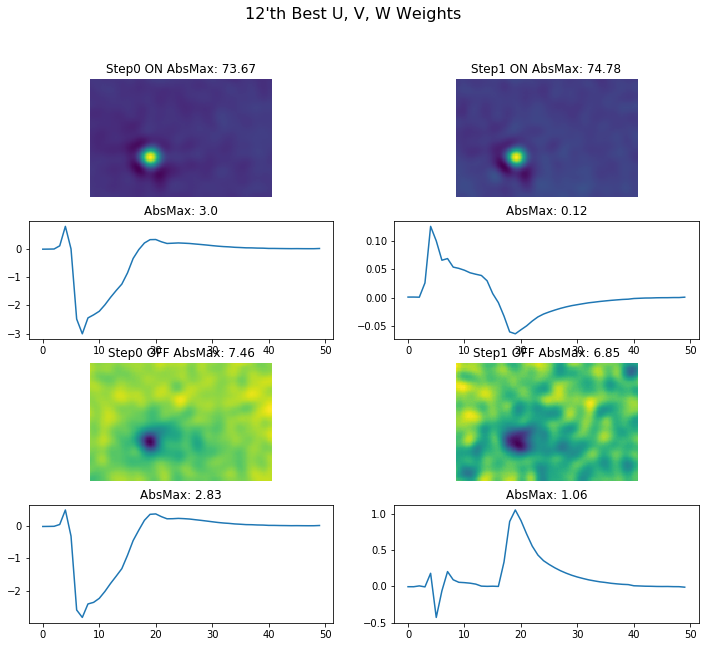

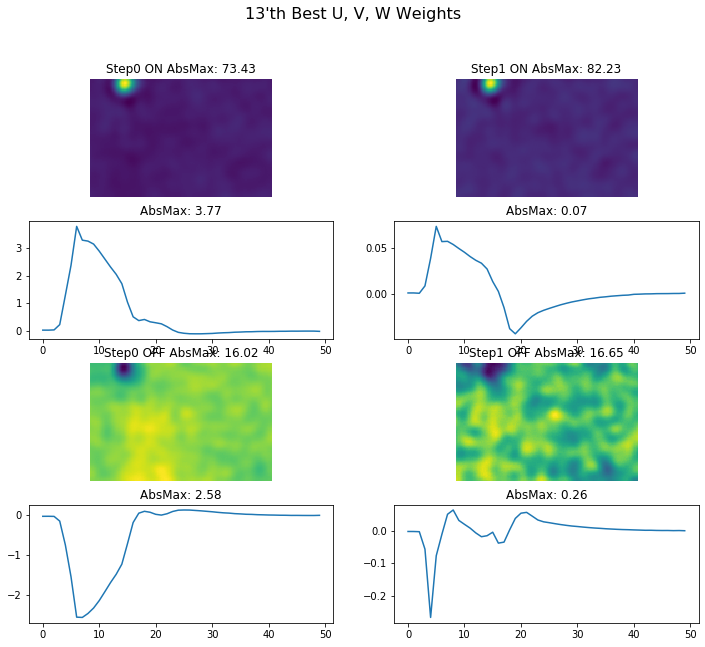

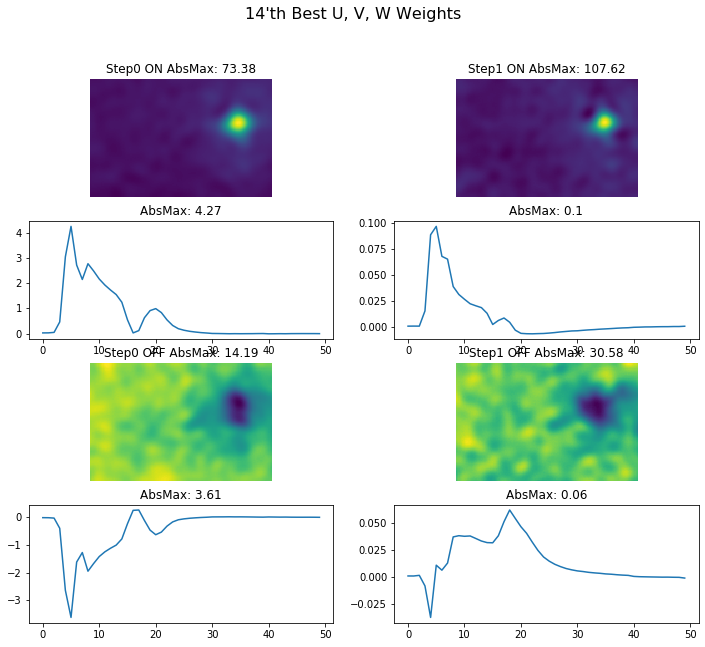

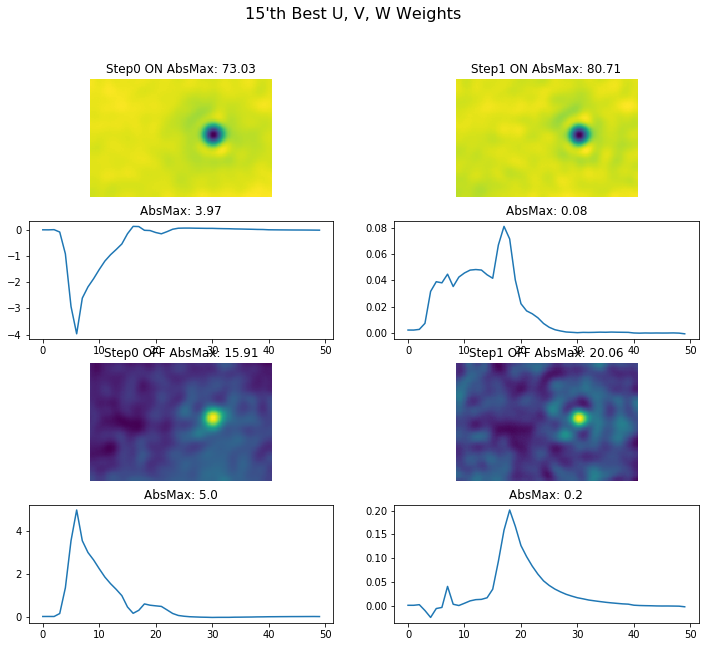

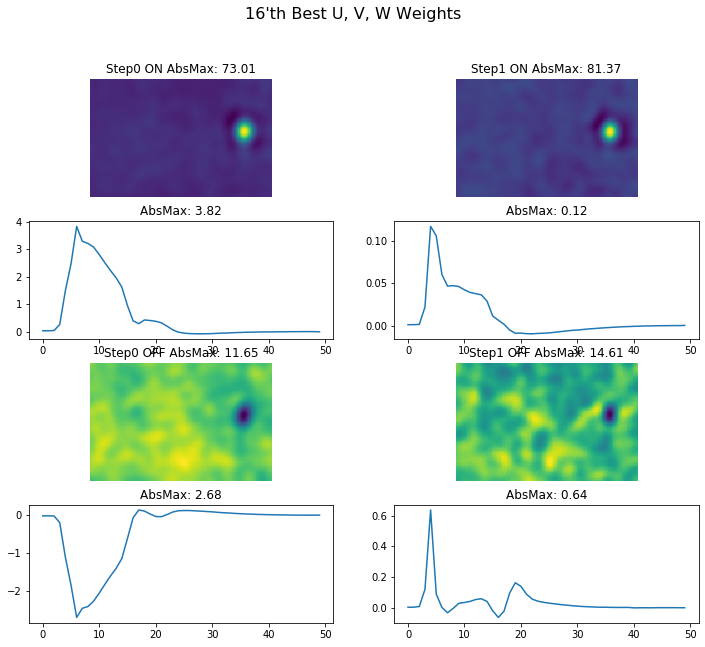

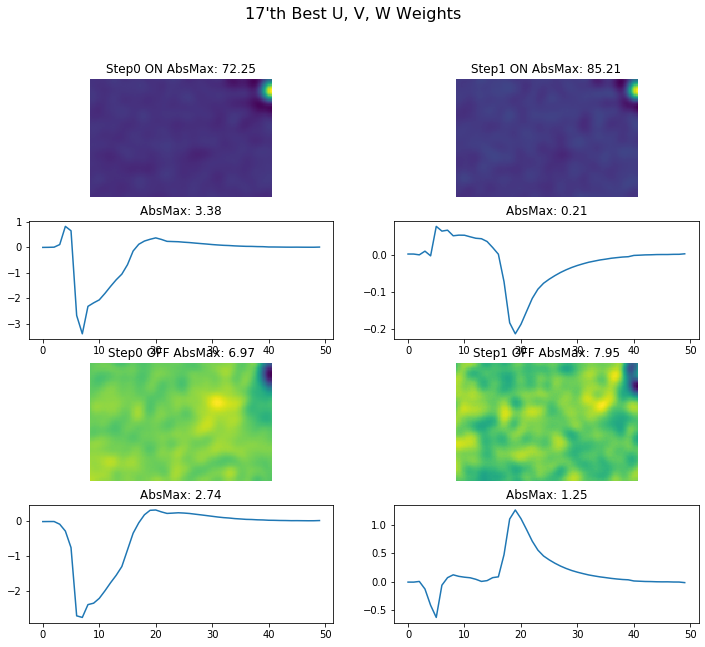

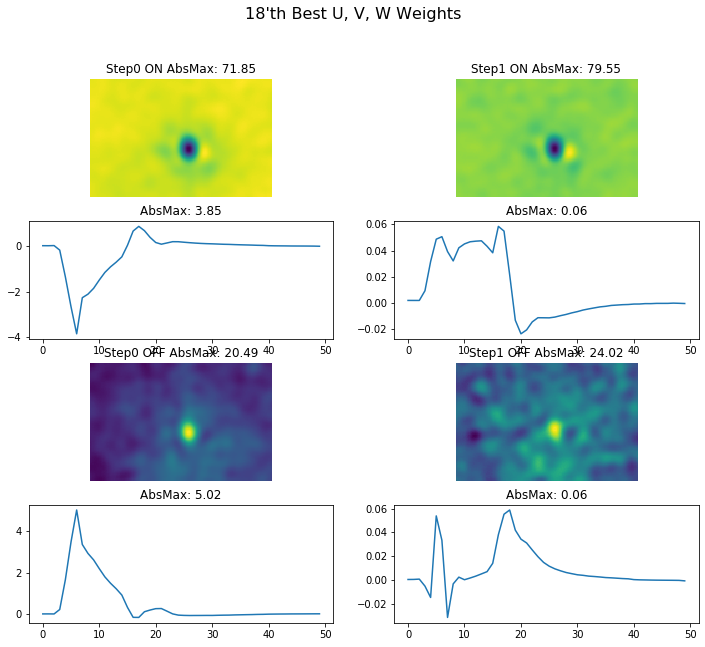

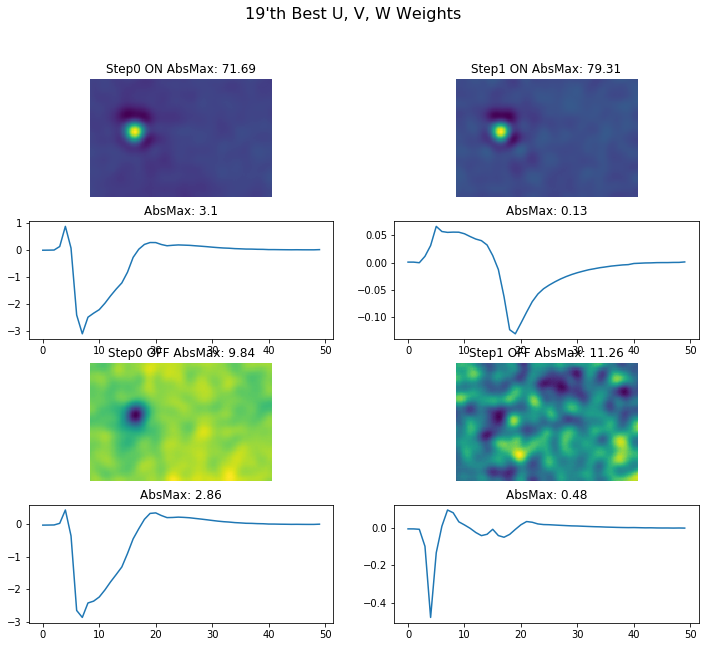

In [21]:
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i1_u1600_r100_W_weights.npy"
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i1_u1600_r100_U_weights.npy"
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i1_u1600_r100_V_weights.npy"
unit_no = 20
save_dir = "/ssd/joon/2017_11_29_ns/figures/"


multi_comb_plot_weights(W_file, U_file, V_file, unit_no, save_dir)

In [18]:
def plot_u_weights(U_file, sorted_units_file, unit_no, save_dir):
    U = np.load(U_file)
    sorted_units = np.load(sorted_units_file)
    

    iter_no = U.shape[0]
    print(iter_no)
    
    """
    plt_ids = np.empty((unit_no*2,))
    
    for i in tnrange(unit_no):
        unit = sorted_units[i]
        plt_ids[i*2] = 2*unit
        plt_ids[i*2+1] = 2*unit+1
        
    plt_ids = plt_ids.astype(np.int)
    """
    fig, axs = plt.subplots(ncols = iter_no, figsize = (12,10))
    
    for i in tnrange(iter_no):
        #img = axs[i].imshow(U[i,plt_ids,:])
        img = axs[i].imshow(U[i,:unit_no*2,:])
        plt.colorbar(img, ax=axs[i])
        axs[i].set_title("Train Step "+str(i), fontsize = 15)
        
    fig.suptitle("Alternating U Weights (Top 30 Units)", fontsize = 16)
        
    
    
    
    

2


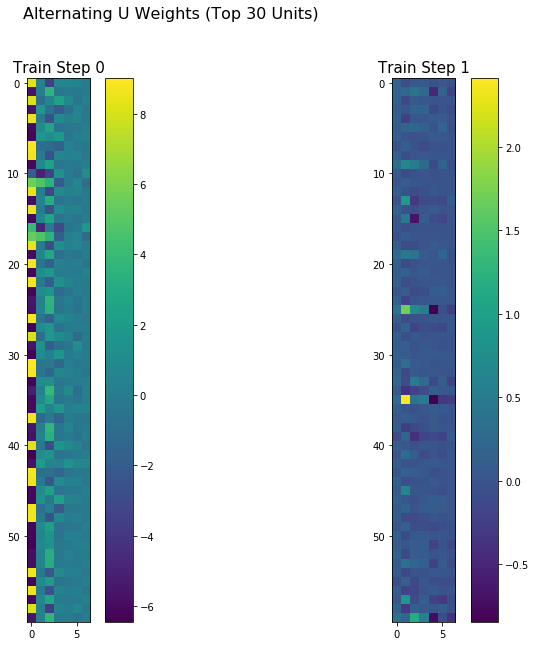

In [19]:
U_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i1_u1600_r100_U_weights.npy"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
unit_no = 30
save_dir = "/ssd/joon/2017_11_29_ns/figures/"


plot_u_weights(U_file, sorted_units_file, unit_no, save_dir)

In [14]:
def plot_v_weights(V_file, save_dir):
    V = np.load(V_file)
    iter_no = V.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no, figsize = (10,6))
    
    for i in tnrange(iter_no):
        img = axs[i].imshow(V[i].T)
        plt.colorbar(img, ax=axs[i])
        axs[i].set_title("Train Step "+str(i), fontsize = 15)
        
    fig.suptitle("Alternating V Weights", fontsize = 16)
    
    
    

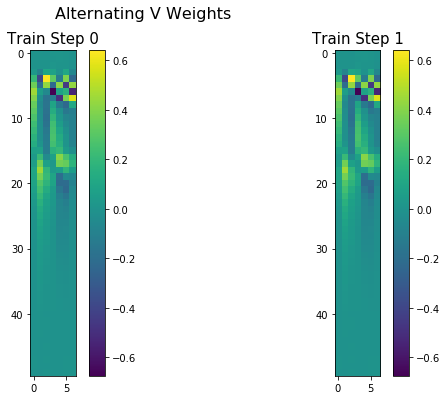

In [15]:
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/noV_altern_i1_u1600_r100_V_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"


plot_v_weights(V_file, save_dir)

In [13]:
def line_plot_v_weights(V_file):
    V = np.load(V_file)
    iter_no = V.shape[0]
    k_dim = V.shape[1]
    
    fig, axs = plt.subplots(nrows = k_dim, ncols = iter_no, figsize = (15,15))
    
    for i in tnrange(iter_no):
        for j in range(k_dim):
            axs[j,i].plot(np.arange(V.shape[2]), V[i,j,:])
            axs[j,i].set_title("Step"+str(i)+" PC"+str(j))
            
    fig.tight_layout()
    

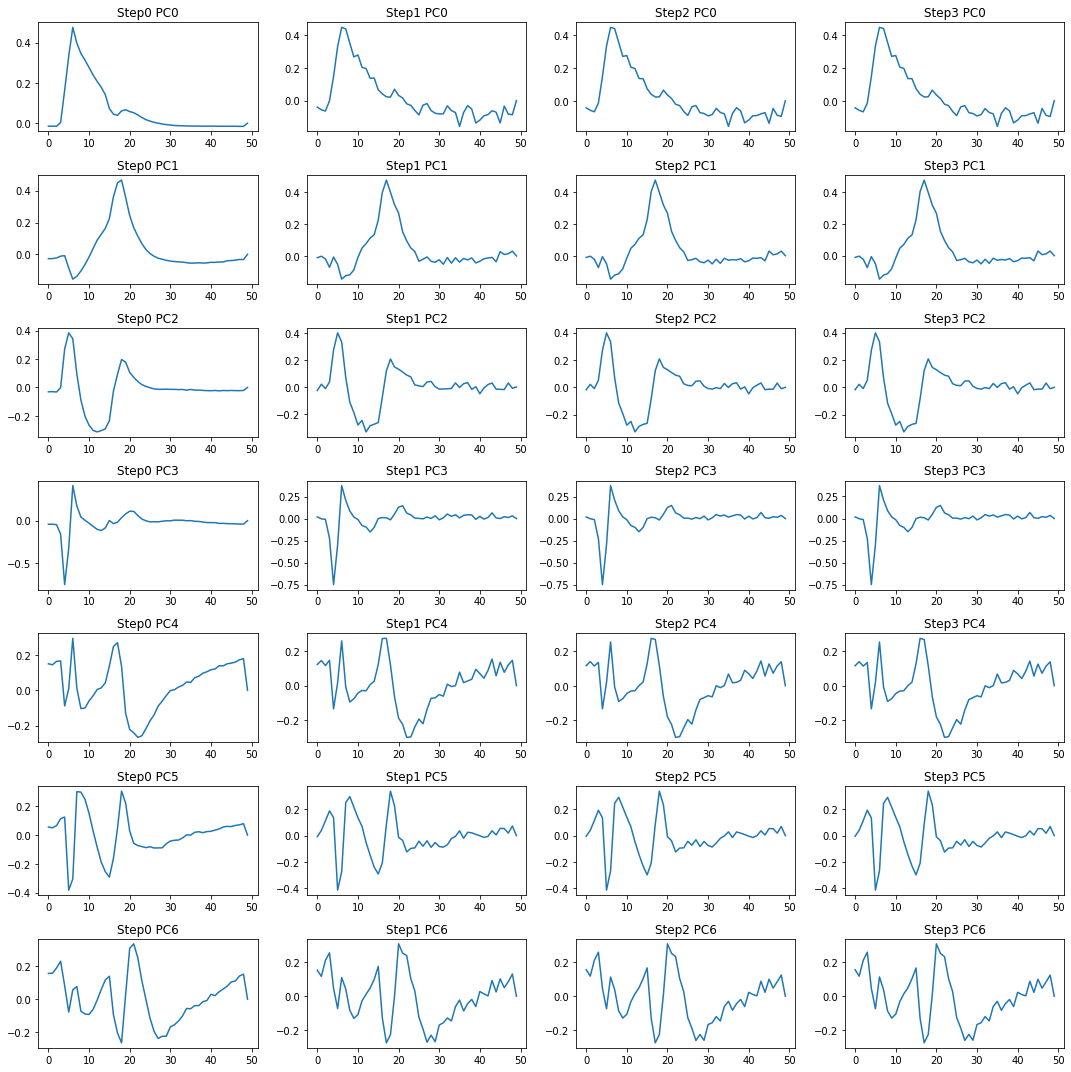

In [14]:
V_file = "/ssd/joon/2017_11_29_ns/yass/weights/lnn_altern_i3_u500_r100_V_weights.npy"


line_plot_v_weights(V_file)

In [10]:
def plot_w_weights(W_file, unit, save_dir):
    
    W = np.load(W_file)
    iter_no = W.shape[0]
    
    fig, axs = plt.subplots(ncols = iter_no, nrows=2, figsize = (12,12))
    
    for i in range(iter_no):
        img0 = axs[0,i].imshow(W[i,:,2*unit].reshape((95,146)).T)
        img1 = axs[1,i].imshow(W[i,:,2*unit+1].reshape((95,146)).T)
        axs[0,i].set_title("Train "+str(i)+" ON")
        axs[1,i].set_title("Train "+str(i)+" OFF")
        axs[0,i].axis("off")
        axs[1,i].axis("off")
        plt.colorbar(img0, ax=axs[0,i], shrink =0.8)
        plt.colorbar(img1, ax=axs[1,i], shrink =0.8)
        
    fig.suptitle("Unit "+str(unit)+ " Alternating W Weights", fontsize = 16, y=0.98)
    #fig.tight_layout()
    
def multi_plot_w_weights(W_file, sorted_units_file, unit_no, save_dir):
    sorted_units = np.load(sorted_units_file)
    
    with PdfPages(os.path.join(save_dir, "yass_lnn_altern_i3_u500_r0_W_weights.pdf")) as pdf:
        for i in tnrange(unit_no):
            #unit = sorted_units[i]
            unit = i
            fig = plot_w_weights(W_file, unit, save_dir)
            pdf.savefig(fig)
            
            
    
    

/home/joon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


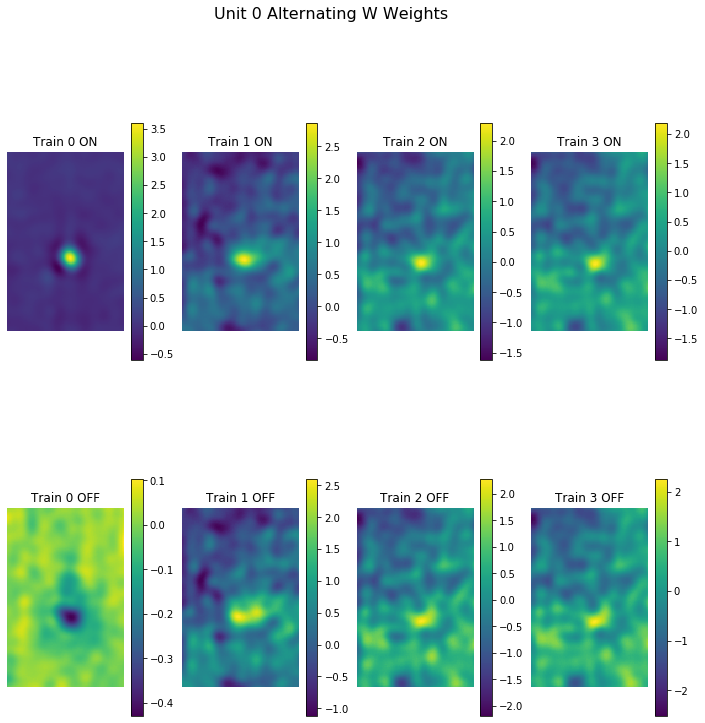

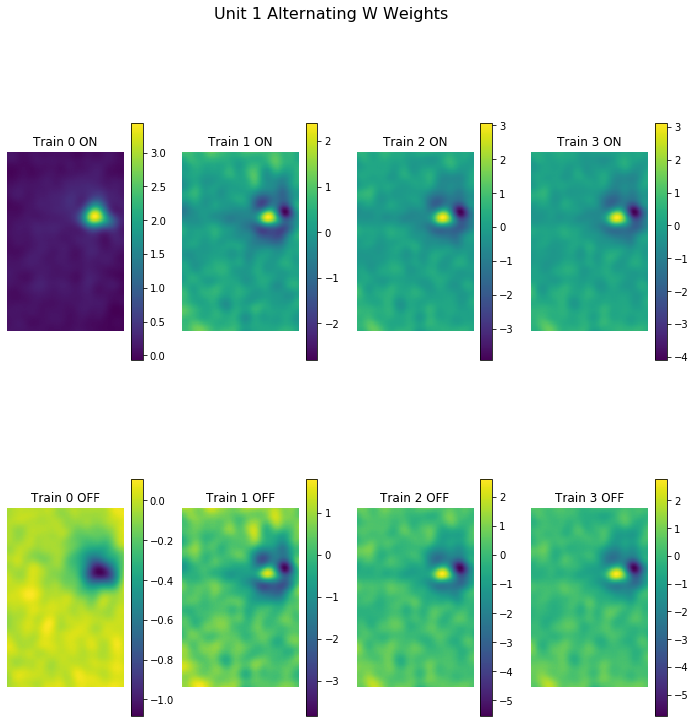

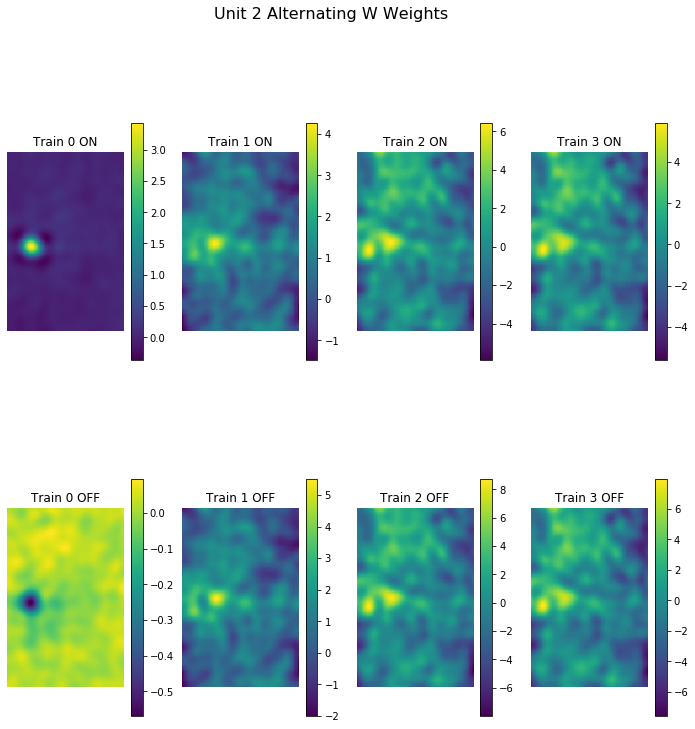

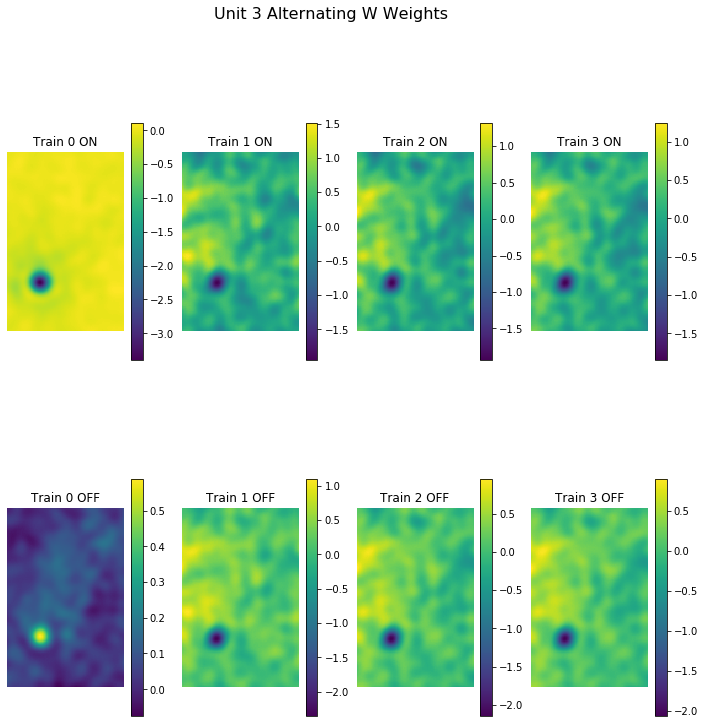

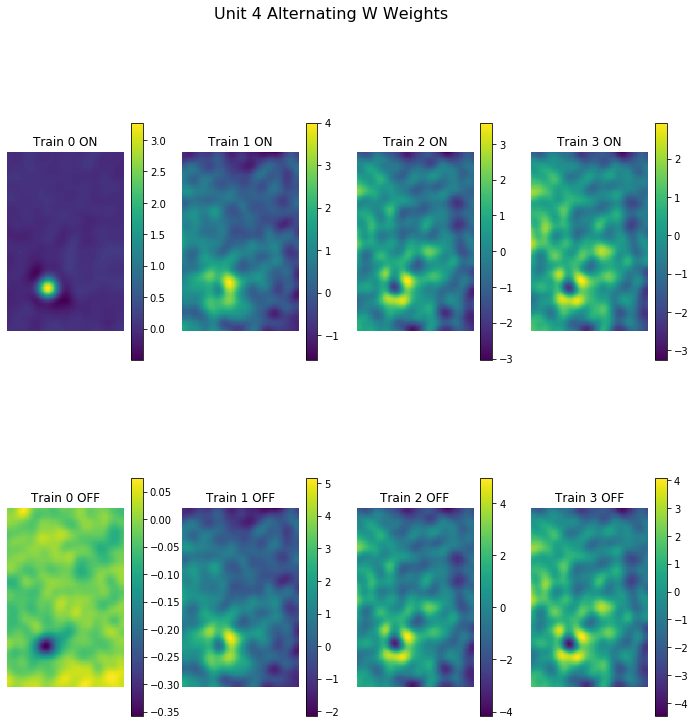

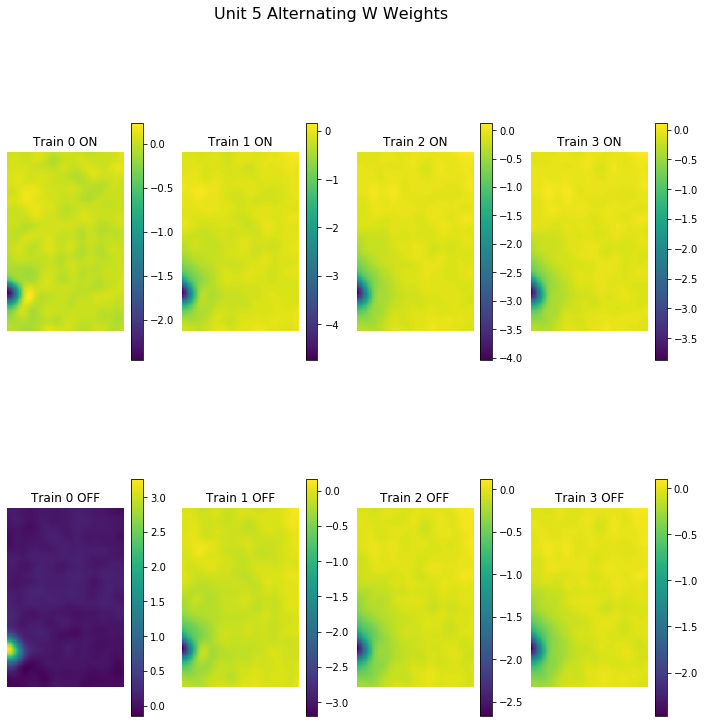

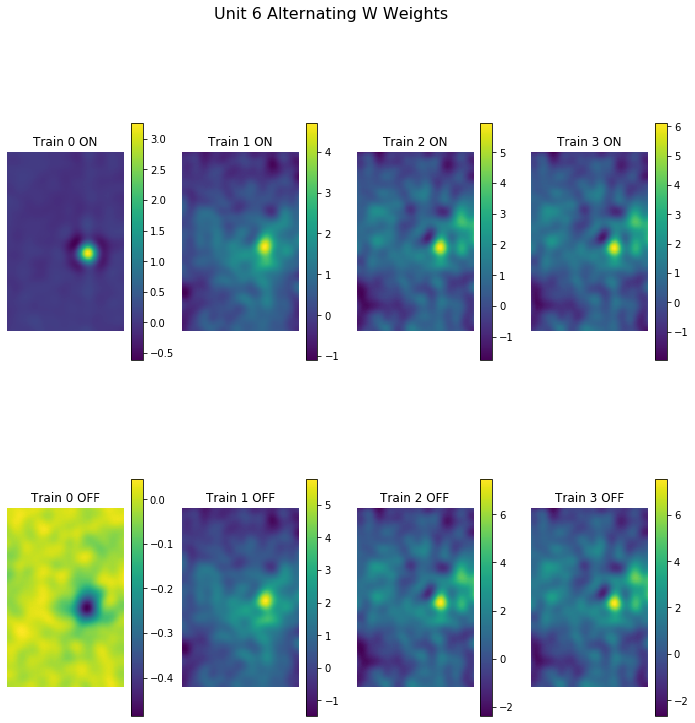

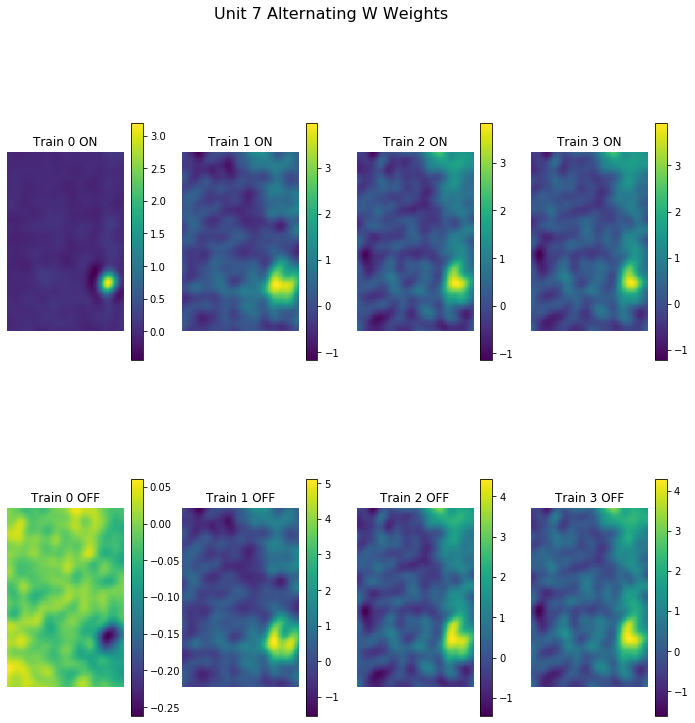

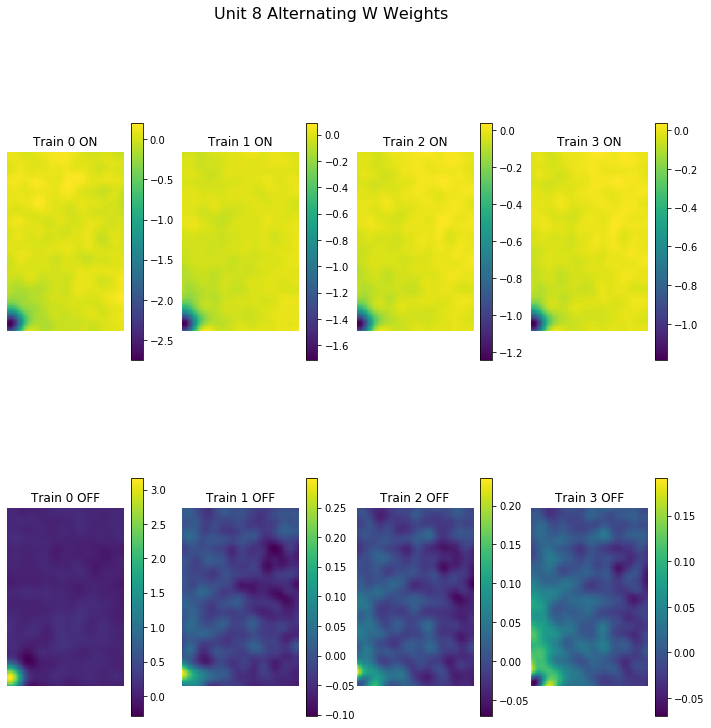

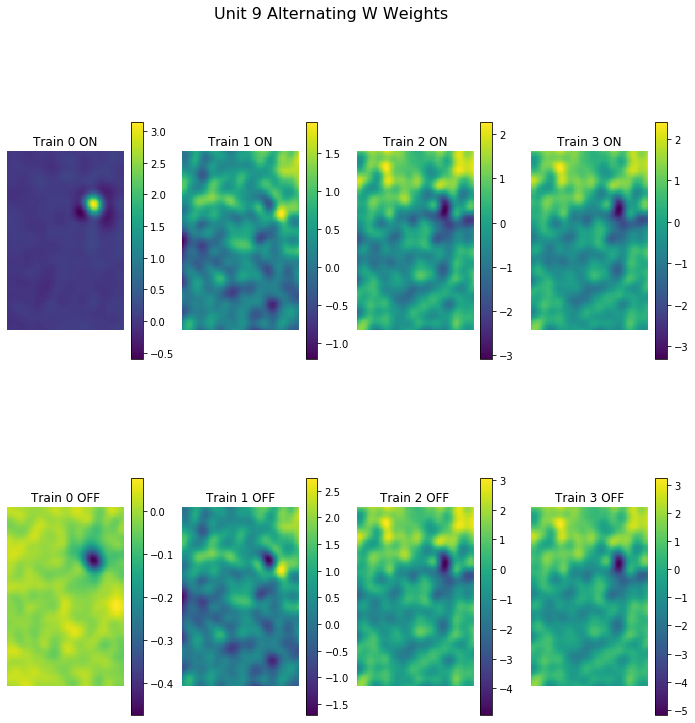

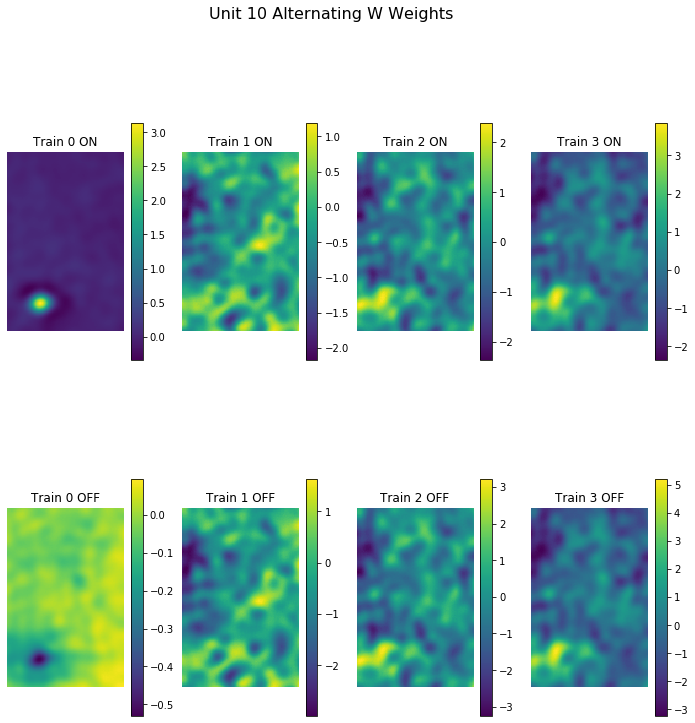

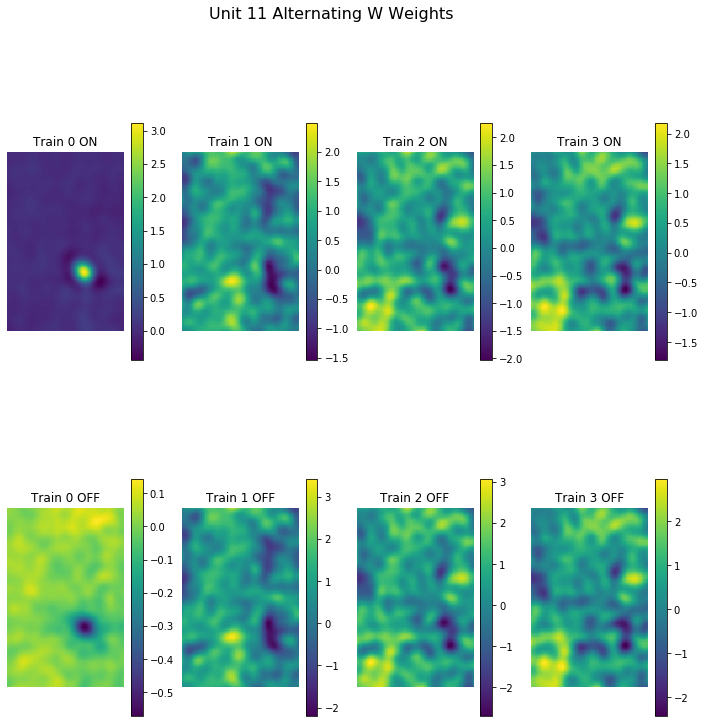

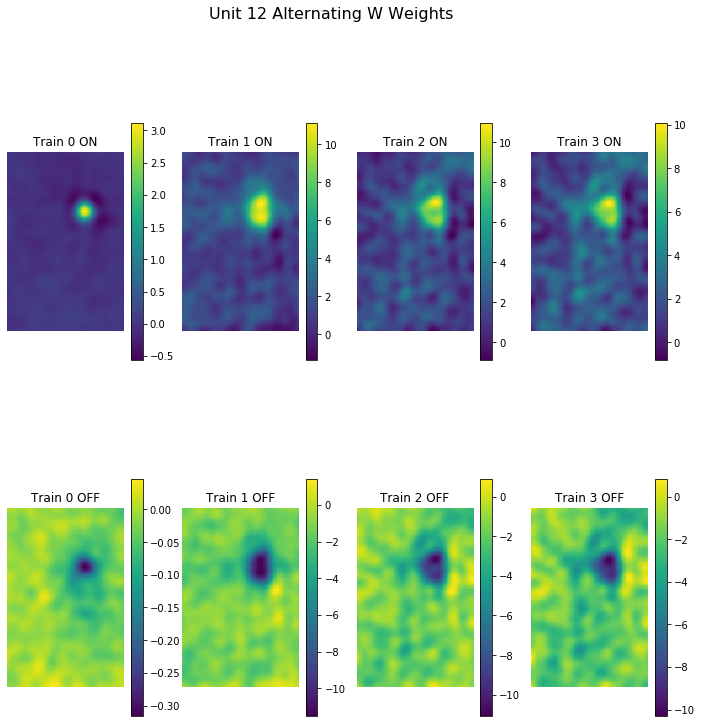

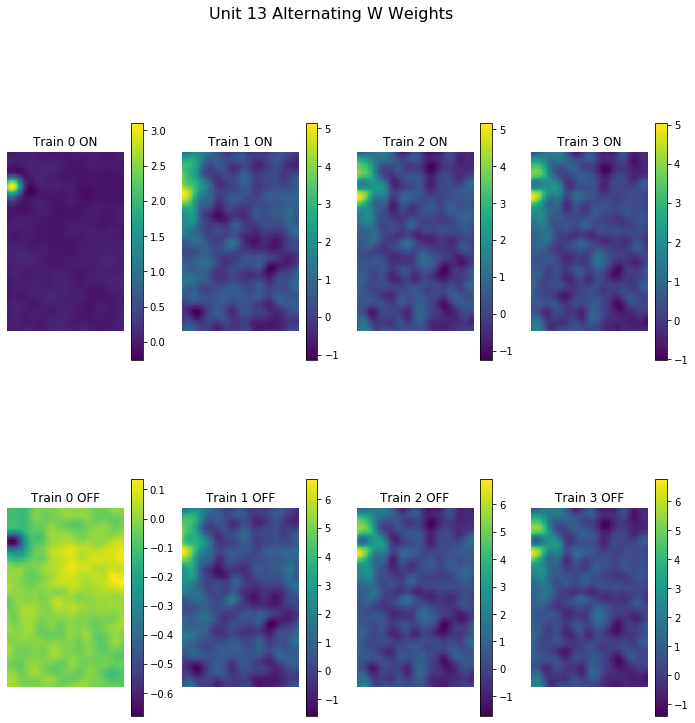

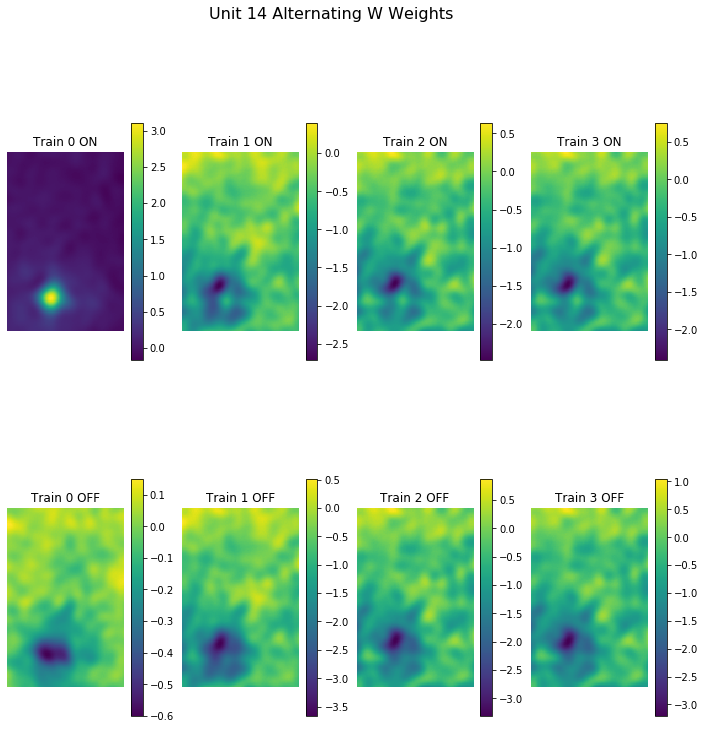

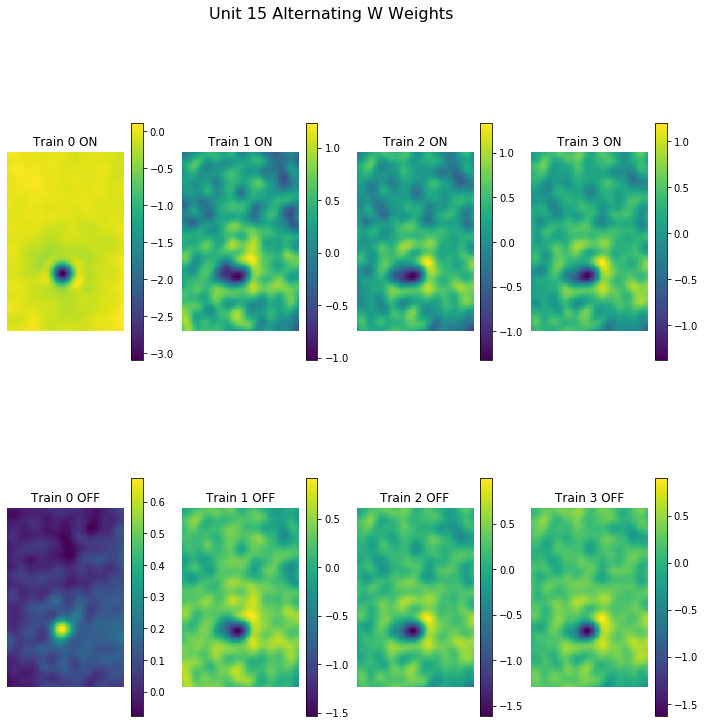

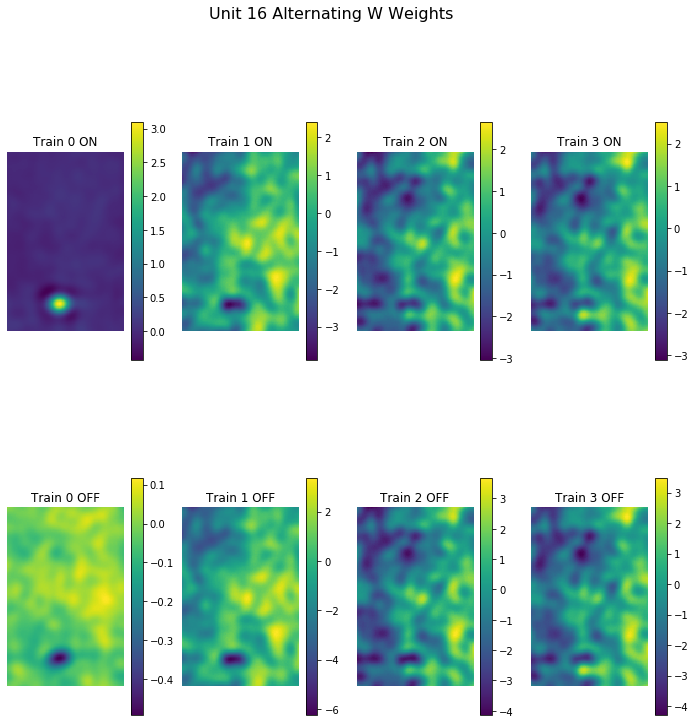

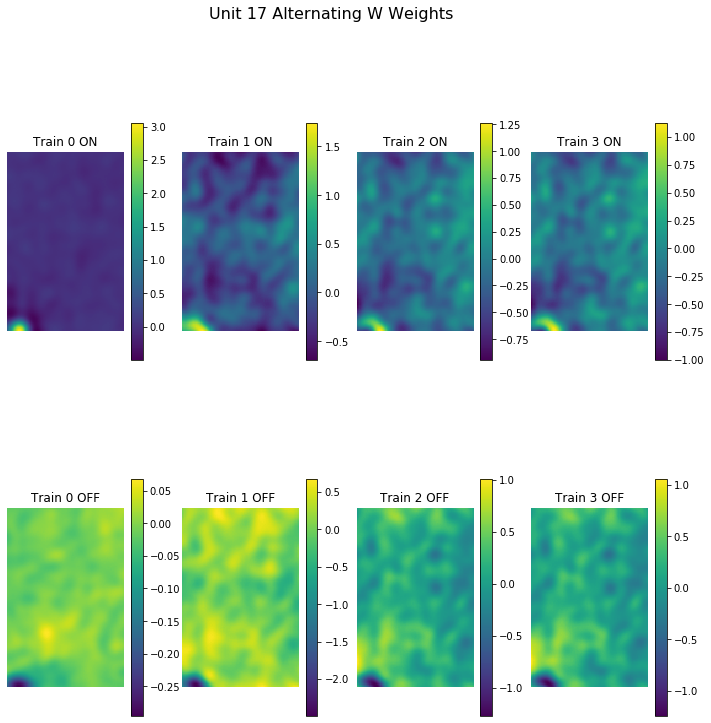

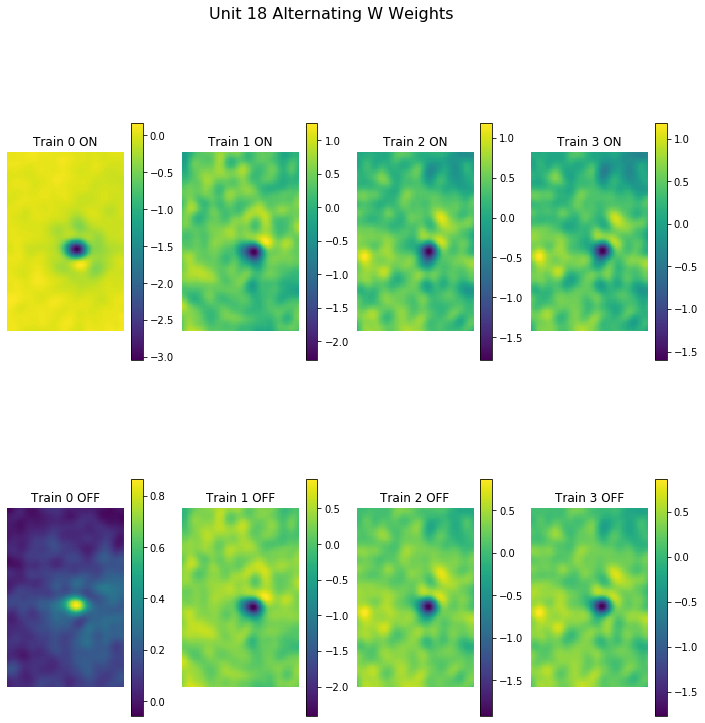

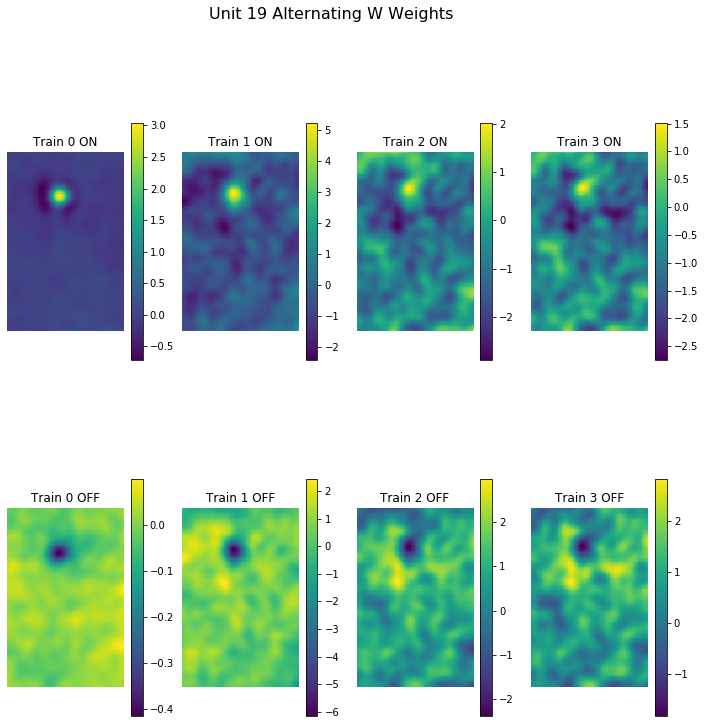

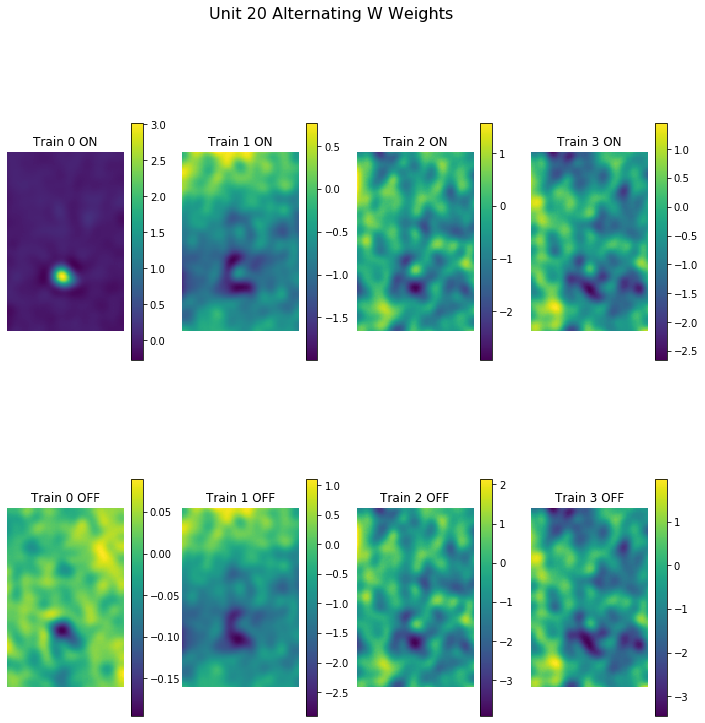

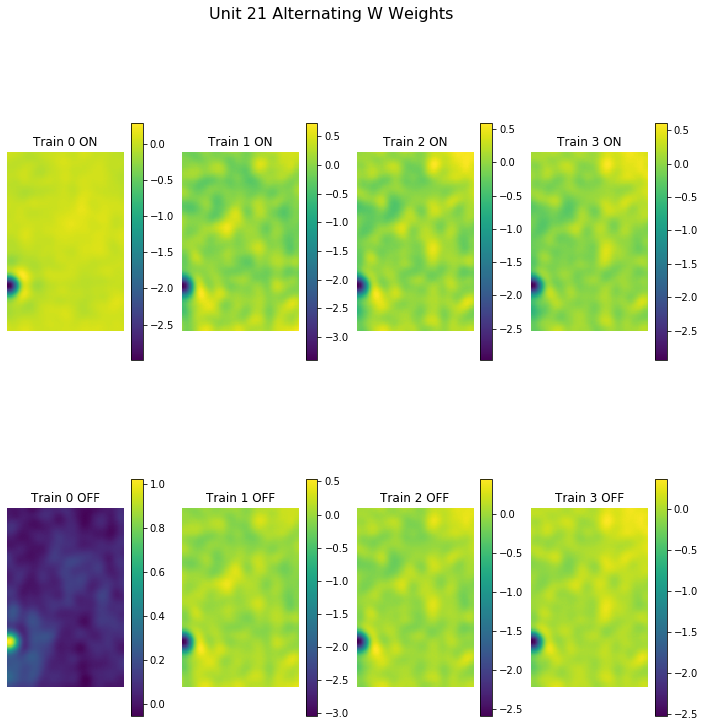

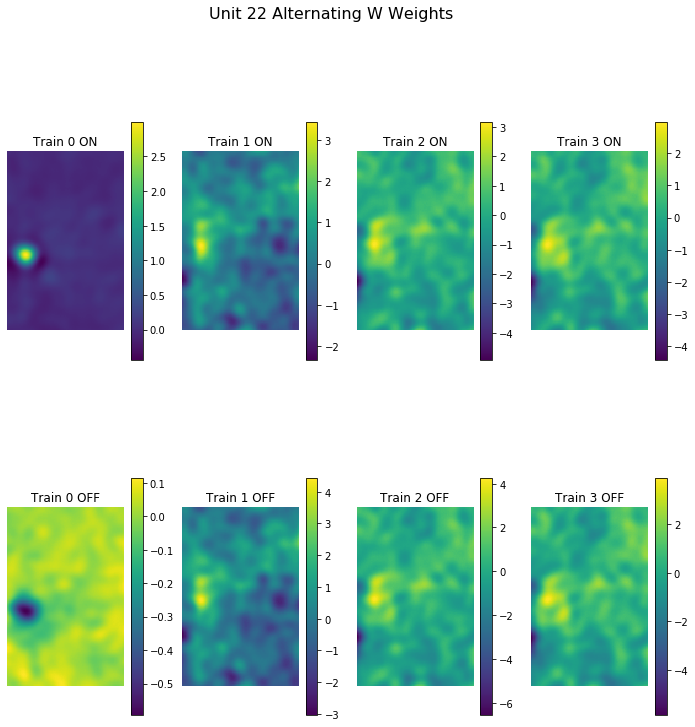

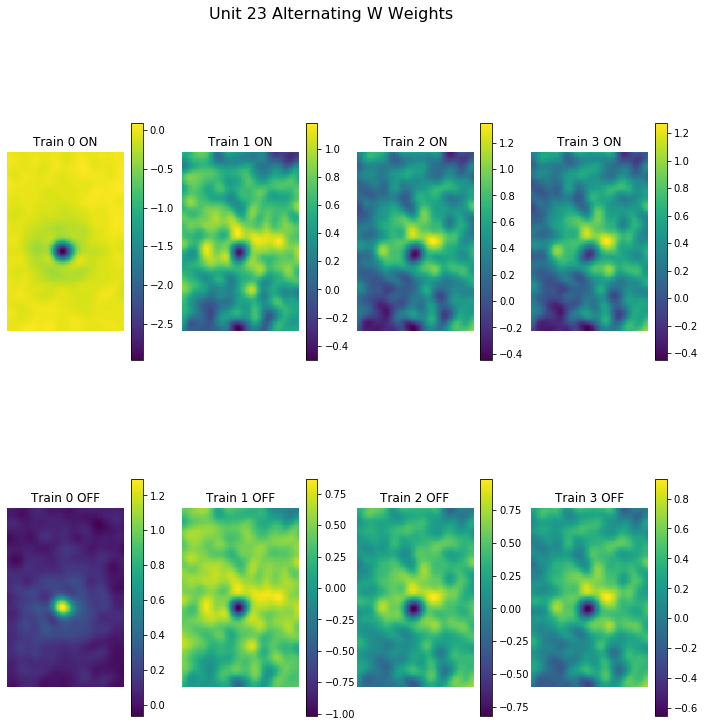

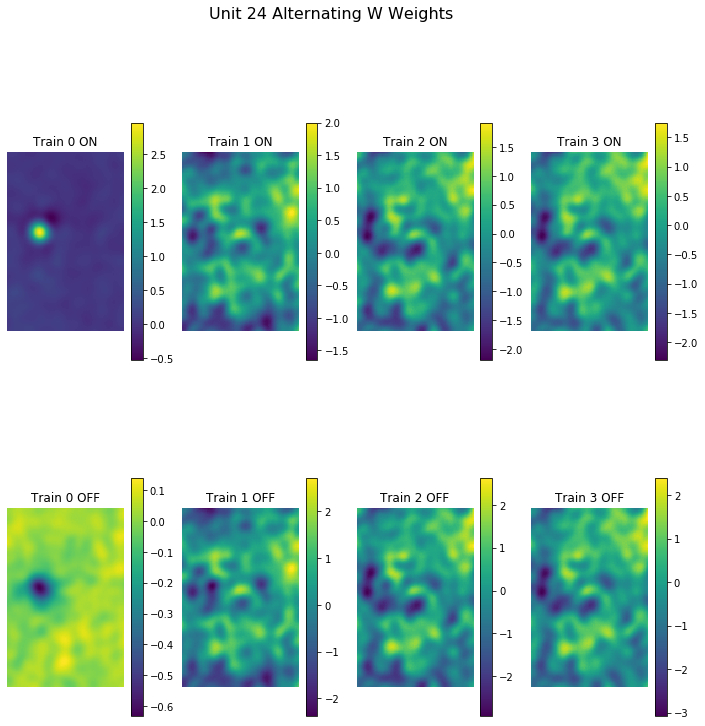

In [11]:
W_file = "/ssd/joon/2017_11_29_ns/yass/weights/lnn_altern_i3_u500_r0_W_weights.npy"
sorted_units_file = "/ssd/joon/2017_11_29_ns/yass/yass_weight_sorted_units.npy"
unit_no = 25
save_dir = "/ssd/joon/2017_11_29_ns/figures/"



multi_plot_w_weights(W_file, sorted_units_file, unit_no, save_dir)